# Sizing & Drawing of Amplifier Core of Biosignal Amplifier

**Copyright 2024 Simon Dorrer**

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at
http://www.apache.org/licenses/LICENSE-2.0

## Packages

In [84]:
# Packages
from pygmid import Lookup as lk
import scipy.constants as sc
import scipy.io as sio
import scipy.integrate as sci
import matplotlib.pyplot as plt
import numpy as np

plt.close("all")
# %matplotlib qt
%matplotlib inline

plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', size = 14)

In [85]:
# read table data
# List of parameters: VGS, VDS, VSB, VTH, VDSS, L, W, NFING, ID, GM, GMB, GDS, CGG, CGB, CGD, CGS, CDD, CSS, STH, SFL
lv_nmos = lk('../data/sg13g2_lv_nmos.mat')
lv_pmos = lk('../data/sg13g2_lv_pmos.mat')

## Functions

In [86]:
# Function for integration of thermal MOSFET noise to output
def noise_spectrum_out(f, T, gamma_m1, gm_m1, gamma_m2, gm_m2, gds_m1, gds_m2, CL):
  return 4 * sc.k * T * (gamma_m1 * gm_m1 + gamma_m2 * gm_m2) / (gds_m1 + gds_m2)**2 * 1 / (1 + (gds_m1 + gds_m2)**2 * (2 * np.pi * f)**2 * CL**2)

In [87]:
def round_to(n, um):
  return round(n / um) * um

## Values from beta-multiplier reference

In [88]:
# Get values from sizing_bias_circuit.ipynb
# Mx /Mxc equals a NMOS transistor cascode, if a 10nA bias current should be created with the BMR circuit.

%store -r Vbiasc
Vbiasc = Vbiasc
print('Vbiasc =', round(float(Vbiasc), 3), 'V')

%store -r Vbias
Vbias = Vbias
print('Vbias =', round(float(Vbias), 3), 'V')

%store -r Ibias
Ibias = Ibias
print('Ibias =', round(float(Ibias * 1e9), 2), 'nA \n')

%store -r l_mxc
l_mxc = round_to(float(l_mxc), 1)
print('l_mxc =', round(float(l_mxc), 1), 'um')

%store -r l_mx
l_mx = round_to(float(l_mx), 1)
print('l_mx =', round(float(l_mx), 1), 'um')

%store -r w_mxc
w_mxc = round_to(float(w_mxc), 1)
print('w_mxc =', round(float(w_mxc), 1), 'um')

%store -r w_mx
w_mx = round_to(float(w_mx), 1)
print('w_mx =', round(float(w_mx), 1), 'um')

Vbiasc = 0.207 V
Vbias = 0.101 V
Ibias = 10.0 nA 

l_mxc = 20.0 um
l_mx = 20.0 um
w_mxc = 5.0 um
w_mx = 5.0 um


## Specifications

In [89]:
# Define the given parameters as taken from the specification table or initial guesses

# Room Temperature
T = 300 # in Kelvin

# Component values of capacitive feedback amplifier (CFA)
C_1 = np.array([330e-12, 165e-12, 33e-12]) # programmable input capacitor (A_0 = 100 = 40dB / 50 = 34dB / 10 = 20dB)
C_2 = 3.3e-12 # feedback capacitor
R_1 = 10e3
R_2 = np.array([320e9, 160e9])  # C = 4fF, fphi = 3.91kHz / 7.81kHz, see sizing_sc_fb_resistor

# Total feedback factor
alpha = np.zeros(len(C_1))
for i in range(len(C_1)):
  alpha[i] = C_2 / (C_1[i] + C_2)
  print('alpha =', round(float(alpha[i]), 2), 'with C_1 =', round(float(C_1[i] * 1e12), 2), 'pF')
print('')

# Set Bandwidth
B = 500

# Define minimum Unit-Gain Bandwidth
f_T = 50e3

# Set global voltages
VDD = 1.5
VSS = 0.0
Vcm = VDD / 2

# Switched-Capacitor Common-Mode Feedbacks
# Same clock f_phi_cmfb, C_1_CMFB and C_2_CMFB in both SC CMFBs.
# NOC frequency for SC CMFB in input and output stage
f_phi_cmfb = 62500
# f_phi_cmfb = 31250

# Capacitors C_1_CMFB and C_2_CMFB
a = 9
C_1_CMFB = 100e-15
C_2_CMFB = a * C_1_CMFB

# Calculate total load capacitance
C_L = 227.56e-15 # load capacitance (see sizing_dac.ipynb "Cin_max = 227.56 fF @ 16 LSB per differential output." or passive low-pass filter (optional))
C_CMFB_tot = C_1_CMFB + C_2_CMFB # total capacitance of SC CMFB in output stage
print('C_CMFB_tot =', round(float(C_CMFB_tot * 1e12), 2), 'pF \n')

# C_CMFB_tot is not in calculated simulation Cload since C_CMFB_tot is built in the circuit.
C_L_tot = np.zeros(len(C_1))
for i in range(len(C_1)):
  C_L_tot[i] = C_L + (1 - alpha[i]) * C_2
  print('C_L_tot =', round(float(C_L_tot[i] * 1e12), 2), 'pF with C_1 =', round(float(C_1[i] * 1e12), 2), 'pF')

# Biggest C_L_tot occurs when alpha is at its smallest value which happens for the biggest C_1 value.
C_L_tot_max = C_L_tot[0]

alpha = 0.01 with C_1 = 330.0 pF
alpha = 0.02 with C_1 = 165.0 pF
alpha = 0.09 with C_1 = 33.0 pF

C_CMFB_tot = 1.0 pF 

C_L_tot = 3.49 pF with C_1 = 330.0 pF
C_L_tot = 3.46 pF with C_1 = 165.0 pF
C_L_tot = 3.23 pF with C_1 = 33.0 pF


## Sizing of NMOS Common-Source Output Stage with Current Source Load

Specifications

In [90]:
# Define the given parameters as taken from the specification table or initial guesses

# Good to know:
# -) M12 / M13 introduces an extra conductance gds2 in parallel to gds1 which decreases the DC open-loop gain but does not impact the gain-bandwidth product (GBWP).
# -) However, the additional capacitance introduced by M12 / M13 can have a noticeable impact on the GBWP if it is a significant fraction of CL.

# Calculate voltages
Vds_m1213 = VDD - Vcm
Vds_m1011 = Vcm
print('Vds_m1213 =', round(float(Vds_m1213), 2), 'V')
print('Vds_m1011 =', round(float(Vds_m1011), 2), 'V \n')

# Set bias current per common-mode output stage
i_bias_cs = 200e-9 # 100e-9 / 200e-9
print('i_bias_cs =', round(float(i_bias_cs) * 1e9, 2), 'nA \n')

# Set Bandwidth
f_1 = 0.15
f_2 = B

# From the above plots we can make an initial guess of gm/ID and the lengths (L)

high_vout = True
high_vgs = not high_vout

# Initial guess of gm/ID
# If gm/ID is small, the output stage is fast and the output noise is reduced but the output voltage swing (Vdsat increases) and the gain is reduced.
# Maximize gm_m1011 for high gain and low vds,sat and minimize gm_m1213 (M12/M13 serves as a current source rather than a transconductor) for adequate gds but useable vds,sat.
# Vds,sat ~ 2 / (gm/ID)
# It depends on the loop gain and cut-off frequency of the first stage how to size M10=M11 and M12=M13.
# gm_id_1011 = gm_id_m1213 for symmetric output voltage swing.
# Decrease gm_id_m1011 if Vgs_m1011 is too small for the input stage (Vds_m34 = Vgs_m34 = Vgs_m1011)!

# The following if / else shows some possible configurations:
# For fair comparison with the push pull stage, the configuration with the same current, Vgs and area (w1213 = w1213 + w1619 + w1720) is chosen.
# Therefore, the final values for simulation are i_bias_cs = 200e-9 / high_vout = True.
if i_bias_cs == 200e-9:
  if high_vout == True:
    # For high output swing (i_bias_cs = 200e-9) --> Simulation
    gm_id_m1213 = 11.3
    gm_id_m1011 = 11.6
    l_1213 = 4 * 10
    l_1011 = 4 * 10
    print('High Output Voltage Swing. \n')
  else: # high_vgs == True:
    # For high Vgs_m1011 (i_bias_cs = 200e-9)
    gm_id_m1213 = 11.3
    gm_id_m1011 = 8.8
    l_1213 = 4 * 10
    l_1011 = 4 * 10
    print('High Vgs. \n')
elif i_bias_cs == 100e-9:
  if high_vout == True:
    # For high output swing (i_bias_cs = 100e-9)
    gm_id_m1213 = 14.7
    gm_id_m1011 = 15
    l_1213 = 4 * 10
    l_1011 = 4 * 10
    print('High Output Voltage Swing. \n')
  else: # high_vgs == True:
    # For high Vgs_m1011 (i_bias_cs = 100e-9)
    gm_id_m1213 = 14.7
    gm_id_m1011 = 11.8
    l_1213 = 4 * 10
    l_1011 = 4 * 10
    print('High Vgs. \n')

print('gm_id_m1213 =', round(float(gm_id_m1213), 2), 'S/A')
print('gm_id_m1011 =', round(float(gm_id_m1011), 2), 'S/A \n')
print('l_1213 =', round(float(l_1213), 2), 'um')
print('l_1011 =', round(float(l_1011), 2), 'um')

# Connect / Disconnect additional Miller capacitance
miller_con = False
Cm = 100e-15

Vds_m1213 = 0.75 V
Vds_m1011 = 0.75 V 

i_bias_cs = 200.0 nA 

High Output Voltage Swing. 

gm_id_m1213 = 11.3 S/A
gm_id_m1011 = 11.6 S/A 

l_1213 = 40.0 um
l_1011 = 40.0 um


CMFB

In [91]:
# Calculating simplified resistive CMFB
# The SC CMFB in the output stage can also be simplified with two serial resistors connected into parallel with two serial capacitors.
R_2_CMFB = 1 / (2 * np.pi * f_phi_cmfb * C_1_CMFB)
print('R_2_CMFB =', round(float(R_2_CMFB) * 1e-6, 2), 'MOhm')

R_2_CMFB = 25.46 MOhm


Thermal Noise Analysis

i_bias_cs = 200.0 nA
gm_id_mp = 11.3 S/A
l_p = 40 um


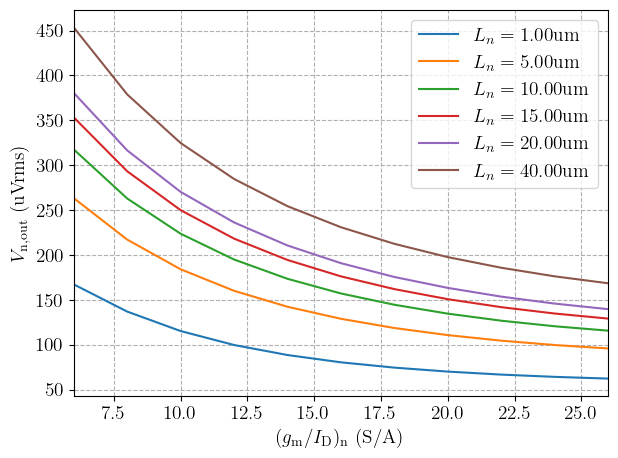

In [92]:
# Looping NMOS gm/ID for several L to find optimal thermal noise for fixed PMOS
# Initial guess for fixed PMOS values:
gm_id_mp = gm_id_m1213
l_p = l_1213

print(f"i_bias_cs = {i_bias_cs * 1e9} nA")
print(f"gm_id_mp = {gm_id_mp} S/A")
print(f"l_p = {l_p} um")

gm_mp = i_bias_cs * gm_id_mp
gm_gds_mp = lv_pmos.lookup("GM_GDS", GM_ID=gm_id_mp, L=l_p, VDS=Vds_m1213, VSB=0)
gds_mp = gm_mp / gm_gds_mp
sth_gm_mp = lv_pmos.lookup('STH_GM', GM_ID=gm_id_mp, L=l_p, VDS=Vds_m1213, VSB=0)
sth_mp = sth_gm_mp * gm_mp
gamma_mp = sth_mp / (4 * sc.k * T * gm_mp)

# Define arrays
gm_id_mn_arr = np.arange(6, 28, 2)
l_n_arr = np.array([1, 5, 10, 15, 20, 40])

# Calculate gm, gds and gamma for NMOS
gm_mn = np.empty((len(l_n_arr), len(gm_id_mn_arr)))
gds_mn = np.empty((len(l_n_arr), len(gm_id_mn_arr)))
gamma_mn = np.empty((len(l_n_arr), len(gm_id_mn_arr)))
Vn_cs_out_rms_num = np.empty((len(l_n_arr), len(gm_id_mn_arr)))
for j in range(len(l_n_arr)):
  for i in range(len(gm_id_mn_arr)):
    gm_mn[j][i] = i_bias_cs * gm_id_mn_arr[i]
    gm_gds_mn = lv_nmos.lookup("GM_GDS", GM_ID=gm_id_mn_arr[i], L=l_n_arr[j], VDS=Vds_m1011, VSB=0)
    gds_mn[j][i] = gm_mn[j][i] / gm_gds_mn
    sth_gm_mn = lv_nmos.lookup('STH_GM', GM_ID=gm_id_mn_arr[i], L=l_n_arr[j], VDS=Vds_m1011, VSB=0)
    sth_mn = sth_gm_mn * gm_mn[j][i]
    gamma_mn[j][i] = sth_mn / (4 * sc.k * T * gm_mn[j][i])

    # take smallest C_L_tot for worst-case output noise
    Vn_cs_out_rms_num[j][i], _ = np.sqrt(sci.quad(noise_spectrum_out, f_1, f_2, args=(T, gamma_mn[j][i], gm_mn[j][i], gamma_mp, gm_mp, gds_mn[j][i], gds_mp, C_L_tot[2]))) # 0.15Hz to B

plt.figure(tight_layout = True)
for j in range(len(l_n_arr)):
  plt.plot(gm_id_mn_arr, Vn_cs_out_rms_num[j] * 1e6, label=f"$L_n = {l_n_arr[j]:.2f}$um")
plt.xlabel("$(g_\mathrm{m} / I_\mathrm{D})_\mathrm{n}$ (S/A)")
plt.ylabel("$V_\mathrm{n,out}$ (uVrms)")
plt.legend()
plt.grid(True, which = "both", linestyle = "--")
plt.xlim(gm_id_mn_arr[0], gm_id_mn_arr[-1])
plt.show()

i_bias_cs = 200.0 nA
gm_id_mn = 11.6 S/A
l_n = 40 um


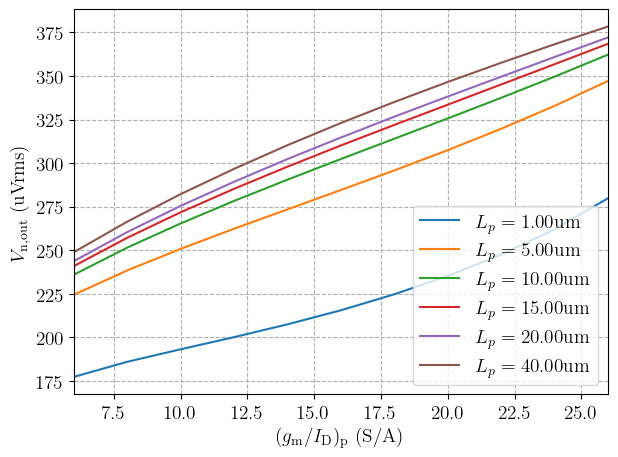

In [93]:
# Looping PMOS gm/ID for several L to find optimal noise for fixed NMOS
# Initial guess for fixed NMOS values:
gm_id_mn = gm_id_m1011
l_n = l_1011

print(f"i_bias_cs = {i_bias_cs * 1e9} nA")
print(f"gm_id_mn = {gm_id_mn} S/A")
print(f"l_n = {l_n} um")

gm_mn = i_bias_cs * gm_id_mn
gm_gds_mn = lv_nmos.lookup("GM_GDS", GM_ID=gm_id_mn, L=l_n, VDS=Vds_m1011, VSB=0)
gds_mn = gm_mn / gm_gds_mn
sth_gm_mn = lv_nmos.lookup('STH_GM', GM_ID=gm_id_mn, L=l_n, VDS=Vds_m1011, VSB=0)
sth_mn = sth_gm_mn * gm_mn
gamma_mn = sth_mn / (4 * sc.k * T * gm_mn)

# Define arrays
gm_id_mp_arr = np.arange(6, 28, 2)
l_p_arr = np.array([1, 5, 10, 15, 20, 40])

# Calculate gm, gds and gamma for PMOS
gm_mp = np.empty((len(l_p_arr), len(gm_id_mp_arr)))
gds_mp = np.empty((len(l_p_arr), len(gm_id_mp_arr)))
gamma_mp = np.empty((len(l_p_arr), len(gm_id_mp_arr)))
Vn_cs_out_rms_num = np.empty((len(l_p_arr), len(gm_id_mp_arr)))
for j in range(len(l_p_arr)):
  for i in range(len(gm_id_mp_arr)):
    gm_mp[j][i] = i_bias_cs * gm_id_mp_arr[i]
    gm_gds_mp = lv_pmos.lookup("GM_GDS", GM_ID=gm_id_mp_arr[i], L=l_p_arr[j], VDS=Vds_m1213, VSB=0)
    gds_mp[j][i] = gm_mp[j][i] / gm_gds_mp
    sth_gm_mp = lv_pmos.lookup('STH_GM', GM_ID=gm_id_mp_arr[i], L=l_p_arr[j], VDS=Vds_m1213, VSB=0)
    sth_mp = sth_gm_mp * gm_mp[j][i]
    gamma_mp[j][i] = sth_mp / (4 * sc.k * T * gm_mp[j][i])

    # take smallest C_L_tot for worst-case output noise
    Vn_cs_out_rms_num[j][i], _ = np.sqrt(sci.quad(noise_spectrum_out, f_1, f_2, args=(T, gamma_mn, gm_mn, gamma_mp[j][i], gm_mp[j][i], gds_mn, gds_mp[j][i], C_L_tot[2]))) # 0.15Hz t0 512Hz

plt.figure(tight_layout = True)
for j in range(len(l_p_arr)):
  plt.plot(gm_id_mp_arr, Vn_cs_out_rms_num[j] * 1e6, label=f"$L_p = {l_p_arr[j]:.2f}$um")
plt.xlabel("$(g_\mathrm{m} / I_\mathrm{D})_\mathrm{p}$ (S/A)")
plt.ylabel("$V_\mathrm{n,out}$ (uVrms)")
plt.legend()
plt.grid(True, which = "both", linestyle = "--")
plt.xlim(gm_id_mp_arr[0], gm_id_mp_arr[-1])
plt.show()

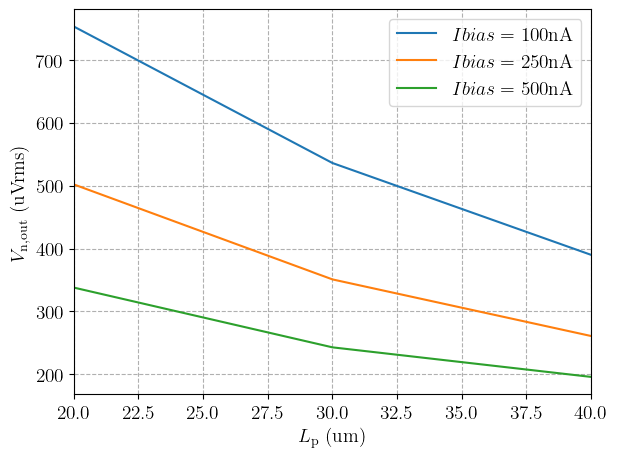

In [94]:
# Simulate and plot output noise (thermal + flicker) against Lp (Ln = Lp / 2) for different Ibias (100n, 250n and 500n) for fixed gm/ID
# The noise is simulated from f1 = 0.15Hz to f2 = B

# Define arrays
l_p_arr = np.array([20, 30, 40])
i_bias_cs_arr = np.array([100e-9, 250e-9, 500e-9])
Vn_cs_out_rms_sim = np.empty((len(i_bias_cs_arr), len(l_p_arr)))

Vn_cs_out_rms_sim[0] = np.array([753, 536, 390]) # 100nA
# Wp[0] = [4, 6, 9]
# Wn[0] = [3, 5, 7]
# Vgs[0] = [0.1983, 0.185, 0.182]

Vn_cs_out_rms_sim[1] = np.array([502, 351, 261]) # 250nA
# Wp[1] = [11, 14, 21]
# Wn[1] = [8, 12, 16]
# Vgs[1] = [0.2079, 0.197, 0.16]

Vn_cs_out_rms_sim[2] = np.array([338, 243, 196]) # 500nA
# Wp[2] = [21, 28, 43]
# Wn[2] = [17, 25, 33]
# Vgs[2] = [0.21, 0.195, 0.1915]


plt.figure(tight_layout = True)
for j in range(len(i_bias_cs_arr)):
  plt.plot(l_p_arr, Vn_cs_out_rms_sim[j], label=f"$Ibias = {i_bias_cs_arr[j] * 1e9:.0f}$nA")
plt.xlabel("$L_\mathrm{p}$ (um)")
plt.ylabel("$V_\mathrm{n,out}$ (uVrms)")
plt.legend()
plt.grid(True, which = "both", linestyle = "--")
plt.xlim(l_p_arr[0], l_p_arr[-1])
plt.show()

In [95]:
# Conclusion:
# If (gm/ID)n is high (weak inversion) and (gm/ID)p is small (strong inversion), the thermal noise minimizes.
# However, with small (gm/ID)p, Vds,sat of Mp increases and therefore the output swing is reduced.

# In the above plots, it seems like to make L small for low output noise but do not forget the flicker noise.
# fco (flicker-thermal noise corner) lies around the closed-loop bandwidth and therefore the flicker noise has much more impact on the output noise than the thermal noise.
# Flicker noise is reduced with longer transistors.
# Furthermore, fco is reduced with higher gm/ID (weak inversion) - see Jespers p. 184.
# Consequently, the smallest thermal noise might not give the best overall noise result during simulation.
# It is important to find the lengths where reduced flicker noise and increased thermal noise are optimized.

# Keep in mind that the feedback network of the CFA high-pass filters the flicker noise.
# For that reason, do not worry if the output noise is still slightly too high after all optimizations.

# The last resort would be to increase the bias current through Mn and Mp.

Look-up

In [96]:
# Look up parameters for chosen gm/ID and L

# Gate-Source Voltage for given L and gm/ID
Vgs_m1213 = lv_pmos.lookupVGS(GM_ID=gm_id_m1213, L=l_1213, VDS=Vds_m1213, VSB=0)
print('Vgs_m1213 =', round(float(Vgs_m1213), 2), 'V')
print('VDD - Vgs_m1213 =', round(float(VDD - Vgs_m1213), 2), 'V')

Vgs_m1011 = lv_nmos.lookupVGS(GM_ID=gm_id_m1011, L=l_1011, VDS=Vds_m1011, VSB=0)
print('Vgs_m1011 =', round(float(Vgs_m1011), 2), 'V \n')

# Transconductance (gm) from gm/ID and ID
gm_m1213 = i_bias_cs * gm_id_m1213
print(f"gm_m1213 = {round(float(gm_m1213) * 1e6, 2)}uS")

gm_m1011 = i_bias_cs * gm_id_m1011
print(f"gm_m1011 = {round(float(gm_m1011) * 1e6, 2)}uS \n")

# Output Conductance (gds)
gm_gds_m1213 = lv_pmos.lookup("GM_GDS", L=l_1213, VGS=Vgs_m1213, VDS=Vds_m1213, VSB=0)
gds_m1213 = gm_m1213 / gm_gds_m1213
print(f"gds_m1213 = {round(float(gds_m1213) * 1e9, 4)}nS (= {round(float(1/gds_m1213) * 1e-6, 2)}MOhm)")

gm_gds_m1011 = lv_nmos.lookup("GM_GDS", L=l_1011, VGS=Vgs_m1011, VDS=Vds_m1011, VSB=0)
gds_m1011 = gm_m1011 / gm_gds_m1011
print(f"gds_m1011 = {round(float(gds_m1011) * 1e9, 4)}nS (= {round(float(1/gds_m1011) * 1e-6, 2)}MOhm) \n")

# Cdd of M10 / M11
gm_Cdd_m1011 = lv_nmos.lookup("GM_CDD", L=l_1011, VGS=Vgs_m1011, VDS=Vds_m1011, VSB=0)
Cdd_m1011 = gm_m1011 / gm_Cdd_m1011
print(f"Cdd_m1011 = {round(float(Cdd_m1011) * 1e15, 2)} fF")

# Cgd of M10 / M11
gm_Cgd_m1011 = lv_nmos.lookup("GM_CGD", L=l_1011, VGS=Vgs_m1011, VDS=Vds_m1011, VSB=0)
Cgd_m1011 = gm_m1011 / gm_Cgd_m1011
print(f"Cgd_m1011 = {round(float(Cgd_m1011) * 1e15, 2)} fF")

# If additional Miller capacitance is connected in parallel:
if miller_con == True:
  Cgd_m1011 = Cgd_m1011 + Cm
  print(f"Cgd_m1011 + Cm = {round(float(Cgd_m1011) * 1e15, 2)} fF")

# Cgg of M10 / M11
gm_Cgg_m1011 = lv_nmos.lookup("GM_CGG", L=l_1011, VGS=Vgs_m1011, VDS=Vds_m1011, VSB=0)
Cgg_m1011 = gm_m1011 / gm_Cgg_m1011
print(f"Cgg_m1011 = {round(float(Cgg_m1011) * 1e15, 2)} fF")

# ID/W
id_W_m1213 = lv_pmos.lookup("ID_W", L=l_1213, VGS=Vgs_m1213, VDS=Vds_m1213, VSB=0)
w_1213 = i_bias_cs / id_W_m1213
print(f"w_1213 = {round(float(w_1213), 2)} um ~ {round_to(float(w_1213), 1)} um (rounded)")

id_W_m1011 = lv_nmos.lookup("ID_W", L=l_1011, VGS=Vgs_m1011, VDS=Vds_m1011, VSB=0)
w_1011 = i_bias_cs / id_W_m1011
print(f"w_1011 = {round(float(w_1011), 2)} um ~ {round_to(float(w_1011), 1)} um (rounded) \n")

# Gamma
sth_gm_m1213 = lv_pmos.lookup('STH_GM', L=l_1213, VGS=Vgs_m1213, VDS=Vds_m1213, VSB=0) # STH thermal noise psd at 1 Hz
sth_m1213 = sth_gm_m1213 * gm_m1213
gamma_m1213 = sth_m1213 / (4 * sc.k * T * gm_m1213)
print(f"gamma_m1213 = {round(float(gamma_m1213), 2)}")

sth_gm_m1011 = lv_nmos.lookup('STH_GM', L=l_1011, VGS=Vgs_m1011, VDS=Vds_m1011, VSB=0) # STH thermal noise psd at 1 Hz
sth_m1011 = sth_gm_m1011 * gm_m1011
gamma_m1011 = sth_m1011 / (4 * sc.k * T * gm_m1011)
print(f"gamma_m1011 = {round(float(gamma_m1011), 2)} \n")

# fco: flicker corner frequency @ flicker noise PSD = thermal noise PSD
fco_m1011 = lv_nmos.lookup('SFL_STH', L=l_1011, VGS=Vgs_m1011, VDS=Vds_m1011, VSB=0)
print(f"fco_m1011 = {round(float(fco_m1011), 2)} Hz")

fco_m1213 = lv_pmos.lookup('SFL_STH', L=l_1213, VGS=Vgs_m1213, VDS=Vds_m1213, VSB=0)
print(f"fco_m1213 = {round(float(fco_m1213), 2)} Hz \n")


Vgs_m1213 = 0.49 V
VDD - Vgs_m1213 = 1.01 V
Vgs_m1011 = 0.3 V 

gm_m1213 = 2.26uS
gm_m1011 = 2.32uS 

gds_m1213 = 1.0443nS (= 957.55MOhm)
gds_m1011 = 20.8765nS (= 47.9MOhm) 

Cdd_m1011 = 1.83 fF
Cgd_m1011 = 1.11 fF
Cgg_m1011 = 553.3 fF
w_1213 = 8.05 um ~ 8 um (rounded)
w_1011 = 2.01 um ~ 2 um (rounded) 

gamma_m1213 = 1.41
gamma_m1011 = 0.75 

fco_m1011 = 590.35 Hz
fco_m1213 = 200.15 Hz 



Sizing of bias circuit

In [97]:
# Sizing of NMOS M14 / M14c
# From the bias circuit (see sizing_bias_circuit.ipynb) we get the Gate-Source voltages for M14 / M14c
Vgs_m14c = Vbiasc
print(f"Vgs_m14c = {round(float(Vgs_m14c), 3)} V")

Vgs_m14 = Vbias
print(f"Vgs_m14 = {round(float(Vgs_m14), 3)} V")

# i_m14 should be a multiple (a) of Ibias
a = 2.5
i_m14 = a * Ibias
print(f"i_m14 = {a} * Ibias = {round(float(i_m14) * 1e9, 2)} nA \n")

# Since the the W/L ratios of the NMOS cascode M2 / M2c in the BMR are known (see sizing_bias_circuit.ipynb), 
# the W/L ratio of the biasing cascode can be calculated for a given current.
# (W/L)2/2c = a * (W/L)14/14c
l_14c = l_mxc
print(f"l_14c = {round(float(l_14c), 2)} um ~ {round_to(float(l_14c), 5)} um (rounded)")

l_14 = l_mx
print(f"l_14 = {round(float(l_14), 2)} um ~ {round_to(float(l_14), 5)} um (rounded)")

w_14c = a * w_mxc
print(f"w_14c = {round(float(w_14c), 2)} um ~ {round(float(w_14c), 1)} um (rounded)")

w_14 = a * w_mx
print(f"w_14 = {round(float(w_14), 2)} um ~ {round(float(w_14), 1)} um (rounded)")

Vgs_m14c = 0.207 V
Vgs_m14 = 0.101 V
i_m14 = 2.5 * Ibias = 25.0 nA 

l_14c = 20.0 um ~ 20 um (rounded)
l_14 = 20.0 um ~ 20 um (rounded)
w_14c = 12.5 um ~ 12.5 um (rounded)
w_14 = 12.5 um ~ 12.5 um (rounded)


In [98]:
# Sizing of PMOS M15
# M15 only mirrors the current to the current-source of the common-source amplifier.
# L is the same length as M12 / M13.
l_15 = l_1213
print(f"l_15 = {round(float(l_15), 2)} um ~ {round_to(float(l_15), 5)} um (rounded)")

# w_15 depends on the current through M14 and the common-source amplifier quiescent current.
i_ratio_cs = i_bias_cs / i_m14
print(f"i_ratio_cs = {round(float(i_ratio_cs), 2)}")

w_15 = w_1213 / i_ratio_cs
print(f"w_15 = {round(float(w_15), 2)} um ~ {round(float(w_15), 1)} um (rounded)")

l_15 = 40.0 um ~ 40 um (rounded)
i_ratio_cs = 8.0
w_15 = 1.01 um ~ 1.0 um (rounded)


Maximum output voltage swing

In [99]:
# Estimate Vds,sat: Vdsat ~ 2 / (gm/ID)
Vds_sat_m1213 = 2 / gm_id_m1213
print('Vds_sat_m1213 =', round(float(Vds_sat_m1213), 3), 'V')

Vds_sat_m1011 = 2 / gm_id_m1011
print('Vds_sat_m1011 =', round(float(Vds_sat_m1011), 3), 'V')

# Calculate maximum output swing
vout_cs_max = VDD - Vds_sat_m1213
vout_cs_min = Vds_sat_m1011
vout_cs = vout_cs_max - vout_cs_min
print(f"vout_cs = vout_cs_max - vout_cs_min = {round(float(vout_cs_max), 2)} - {round(float(vout_cs_min), 2)} = {round(float(vout_cs), 2)} V at VDD = {round(float(VDD), 2)} V")

Vds_sat_m1213 = 0.177 V
Vds_sat_m1011 = 0.172 V
vout_cs = vout_cs_max - vout_cs_min = 1.32 - 0.17 = 1.15 V at VDD = 1.5 V


Open-loop gain

In [100]:
# Calculate open-loop gain of common-source output stage without R_2_CMFB (SC CMFB)
A_ol_0_cs_wo_R = gm_m1011 / (gds_m1011 + gds_m1213)
A_ol_0_cs_wo_R_dB = 20 * np.log10(A_ol_0_cs_wo_R)
print('A_ol_0_cs_wo_R =', round(float(A_ol_0_cs_wo_R), 2), '/', round(float(A_ol_0_cs_wo_R_dB), 2), 'dB without R_2_CMFB (SC CMFB)')

# Calculate open-loop gain of common-source output stage with R_2_CMFB
A_ol_0_cs = gm_m1011 / (gds_m1011 + gds_m1213 + 1 / R_2_CMFB)
A_ol_0_cs_dB = 20 * np.log10(A_ol_0_cs)
print('A_ol_0_cs =', round(float(A_ol_0_cs), 2), '/', round(float(A_ol_0_cs_dB), 2), 'dB with R_2_CMFB =', round(float(R_2_CMFB) * 1e-6, 2), 'MOhm')

# Conclusion:
# R_2_CMFB limits the open-loop gain. A SC CMFB improves this limitation a lot!

A_ol_0_cs_wo_R = 105.84 / 40.49 dB without R_2_CMFB (SC CMFB)
A_ol_0_cs = 37.91 / 31.58 dB with R_2_CMFB = 25.46 MOhm


Cut-off frequency (open-loop bandwidth)

In [101]:
# Cut-off frequency of common-source output stage without R_2_CMFB (SC CMFB) and C_L_tot_max
f_c_cs_wo_R = (gds_m1011 + gds_m1213) / (2 * np.pi * (Cdd_m1011 + C_L_tot_max - C_CMFB_tot + Cgd_m1011 * (1 - 1 / A_ol_0_cs_wo_R)))
print('f_c_cs_wo_R =', round(float(f_c_cs_wo_R * 1e-3), 2), 'kHz without R_2_CMFB and C_L_tot_max =', round(float(C_L_tot_max * 1e12), 2), 'pF')

# Cut-off frequency of common-source output stage with R_2_CMFB and C_L_tot_max
f_c_cs = (gds_m1011 + gds_m1213 + 1 / R_2_CMFB) / (2 * np.pi * (Cdd_m1011 + C_L_tot_max + Cgd_m1011 * (1 - 1 / A_ol_0_cs)))
print('f_c_cs =', round(float(f_c_cs * 1e-3), 2), 'kHz with R_2_CMFB =', round(float(R_2_CMFB) * 1e-6, 2), 'MOhm and C_L_tot_max =', round(float(C_L_tot_max * 1e12), 2), 'pF')

# Conclusion:
# R_2_CMFB increases the cut-off frequency of the open-loop transfer function.
# This should be clear since the open-loop gain is reduced with R_2_CMFB.

f_c_cs_wo_R = 1.4 kHz without R_2_CMFB and C_L_tot_max = 3.49 pF
f_c_cs = 2.78 kHz with R_2_CMFB = 25.46 MOhm and C_L_tot_max = 3.49 pF


Unity-gain bandwidth

In [102]:
# Unity-gain bandwidth of common-source output stage with R_2_CMFB and C_L_tot_max
f_u_cs = (gm_m1011) / (2 * np.pi * (Cdd_m1011 + C_L_tot_max + Cgd_m1011 * (1 - 1 / A_ol_0_cs)))
print('f_u_cs =', round(float(f_u_cs * 1e-3), 2), 'kHz with C_L_tot_max =', round(float(C_L_tot_max * 1e12), 2), 'pF')

# Verify with Gain-Bandwidth Product
GBWP_cs = A_ol_0_cs * f_c_cs
print('GBWP_cs = A_ol_0_cs * f_c_cs =', round(float(GBWP_cs * 1e-3), 2), 'kHz = f_u_cs')

# Conclusion:
# fu does not depend on R_2_CMFB.

f_u_cs = 105.56 kHz with C_L_tot_max = 3.49 pF
GBWP_cs = A_ol_0_cs * f_c_cs = 105.56 kHz = f_u_cs


Right-Hand-Zero (RHZ)

In [103]:
# Right-Hand-Zero (RHZ) frequency
f_z_cs = (gm_m1011) / (2 * np.pi * Cgd_m1011)
print('f_z_cs =', round(float(f_z_cs * 1e-6), 2), 'MHz')

f_z_cs = 331.64 MHz


Thermal output noise

In [104]:
# Calculate thermal output noise of common-source output stage from f_1 to f_2 numerical
# Keep in mind that the simulated output noise will be higher due to flicker noise especially at low frequencies!
Vn_cs_out_rms_num = np.zeros(len(C_1))
for i in range(len(C_1)):
  Vn_cs_out_rms_num[i], _ = np.sqrt(sci.quad(noise_spectrum_out, f_1, f_2, args=(T, gamma_m1011, gm_m1011, gamma_m1213, gm_m1213, gds_m1011, gds_m1213, C_L_tot[i]))) # 0.15Hz t0 512Hz
  print(f"Vn_cs_out_rms_num = {round(float(Vn_cs_out_rms_num[i] * 1e6), 2)} uVrms (thermal noise) from f_1 = {round(float(f_1), 2)} Hz to f_2 = {round(float(f_2), 2)} Hz with C_1 = {round(float(C_1[i] * 1e12), 2)} pF")

Vn_cs_out_rms_num = 291.75 uVrms (thermal noise) from f_1 = 0.15 Hz to f_2 = 500.0 Hz with C_1 = 330.0 pF
Vn_cs_out_rms_num = 291.75 uVrms (thermal noise) from f_1 = 0.15 Hz to f_2 = 500.0 Hz with C_1 = 165.0 pF
Vn_cs_out_rms_num = 291.75 uVrms (thermal noise) from f_1 = 0.15 Hz to f_2 = 500.0 Hz with C_1 = 33.0 pF


In [105]:
# Calculate thermal output noise of common-source output stage from 0 to infinity analytical
Vn_cs_out_rms_ana = np.zeros(len(C_1))
for i in range(len(C_1)):
  Vn_cs_out_rms_ana[i] = np.sqrt((gamma_m1011 * gm_m1011 + gamma_m1213 * gm_m1213) / (gds_m1011 + gds_m1213) * sc.k * T / C_L_tot[i])
  print(f"Vn_cs_out_rms_ana = {round(float(Vn_cs_out_rms_ana[i] * 1e6), 2)} uVrms from 0Hz to infinity Hz with C_1 = {round(float(C_1[i] * 1e12), 2)} pF")

Vn_cs_out_rms_ana = 516.74 uVrms from 0Hz to infinity Hz with C_1 = 330.0 pF
Vn_cs_out_rms_ana = 519.12 uVrms from 0Hz to infinity Hz with C_1 = 165.0 pF
Vn_cs_out_rms_ana = 537.71 uVrms from 0Hz to infinity Hz with C_1 = 33.0 pF


Large-signal slewing time

In [106]:
# Calculate large-signal slewing time with the calculated bias current and maximum output swing
t_slew_cs = (Cdd_m1011 + C_L_tot_max + Cgd_m1011 * (1 - 1 / A_ol_0_cs)) * vout_cs / i_bias_cs
print('slewing time ~', round(t_slew_cs * 1e6, 2), 'us with R_2_CMFB =', round(float(R_2_CMFB) * 1e-6, 2), 'MOhm and C_L_tot_max =', round(float(C_L_tot_max * 1e12), 2), 'pF')

slewing time ~ 20.12 us with R_2_CMFB = 25.46 MOhm and C_L_tot_max = 3.49 pF


Summarize results

In [107]:
# Print out final design values
print('Common-source output stage dimensioning:')
print('-----------------------------------------------')
print('M12/13: W =', round(w_1213, 1), 'um, L =', l_1213, 'um')
print('M10/11: W =', round(w_1011, 1), 'um, L =', l_1011, 'um')
print()
print('Common-source output stage biasing dimensioning:')
print('-----------------------------------------------')
print('M15: W =', round(w_15, 1), 'um, L =', l_15, 'um')
print('M14: W =', round(w_14, 1), 'um, L =', l_14, 'um')
print()
print('Common-source output stage performance summary:')
print('-----------------------------------------------')
print('Vgs_m1011 =', round(float(Vgs_m1011), 2), 'V')
print('Ibias = i_m14 =', round(float(i_m14) * 1e9, 1), 'nA')
print('i_m1011 =', round(float(i_bias_cs) * 1e9, 1), 'nA')
print('total supply current of common-source stage = i_m14 + 2 * i_m1011 =', round(float((i_m14 + 2 * i_bias_cs)) * 1e9, 1), 'nA')
print(f"vout_cs = vout_cs_max - vout_cs_min = {round(float(vout_cs_max), 2)} - {round(float(vout_cs_min), 2)} = {round(float(vout_cs), 2)} V at VDD = {round(float(VDD), 2)} V")
print('A_ol_0_cs_wo_R =', round(float(A_ol_0_cs_wo_R), 2), '/', round(float(A_ol_0_cs_wo_R_dB), 2), 'dB without R_2_CMFB (SC CMFB)')
print('A_ol_0_cs =', round(float(A_ol_0_cs), 2), '/', round(float(A_ol_0_cs_dB), 2), 'dB with R_2_CMFB =', round(float(R_2_CMFB) * 1e-6, 2), 'MOhm')
print('f_c_cs_wo_R =', round(float(f_c_cs_wo_R * 1e-3), 2), 'kHz without R_2_CMFB (SC CMFB) and C_L_tot_max =', round(float(C_L_tot_max * 1e12), 2), 'pF')
print('f_c_cs =', round(float(f_c_cs * 1e-3), 2), 'kHz with R_2_CMFB =', round(float(R_2_CMFB) * 1e-6, 2), 'MOhm and C_L_tot_max =', round(float(C_L_tot_max * 1e12), 2), 'pF')
print('GBWP_cs = A_ol_0_cs * f_c_cs =', round(float(GBWP_cs * 1e-3), 2), 'kHz = f_u_cs')
print('f_z_cs =', round(float(f_z_cs * 1e-6), 2), 'MHz')
print('thermal output noise =', round(Vn_cs_out_rms_num[0] * 1e6, 1), 'uVrms')
print('slewing time ~', round(t_slew_cs * 1e6, 2), 'us')
print('-----------------------------------------------')

Common-source output stage dimensioning:
-----------------------------------------------
M12/13: W = 8.0 um, L = 40 um
M10/11: W = 2.0 um, L = 40 um

Common-source output stage biasing dimensioning:
-----------------------------------------------
M15: W = 1.0 um, L = 40 um
M14: W = 12.5 um, L = 20 um

Common-source output stage performance summary:
-----------------------------------------------
Vgs_m1011 = 0.3 V
Ibias = i_m14 = 25.0 nA
i_m1011 = 200.0 nA
total supply current of common-source stage = i_m14 + 2 * i_m1011 = 425.0 nA
vout_cs = vout_cs_max - vout_cs_min = 1.32 - 0.17 = 1.15 V at VDD = 1.5 V
A_ol_0_cs_wo_R = 105.84 / 40.49 dB without R_2_CMFB (SC CMFB)
A_ol_0_cs = 37.91 / 31.58 dB with R_2_CMFB = 25.46 MOhm
f_c_cs_wo_R = 1.4 kHz without R_2_CMFB (SC CMFB) and C_L_tot_max = 3.49 pF
f_c_cs = 2.78 kHz with R_2_CMFB = 25.46 MOhm and C_L_tot_max = 3.49 pF
GBWP_cs = A_ol_0_cs * f_c_cs = 105.56 kHz = f_u_cs
f_z_cs = 331.64 MHz
thermal output noise = 291.7 uVrms
slewing time ~ 20.1

Simulation with idealized CMFB (R_2_CMFB)

In [108]:
# In the final circuit stacked transistors are used. 
# With the BMR, the stacked transistors, the body effect increases and therefore Vgs_m1011 changes slightly.
Vgs_m1011 = 0.345

# The final values obtained during simulation are:

# The width of M15 changed from 1.0um to 2.0um and the width of M14 / M14c changed from 12.5um to 11.5um, to set Vcm to 0.75V at the output.
# This is due to the resistors. For a SC CMFB, the widths will probably change back again.
# If w_15 is decreased, Vcm is increased.
w_15 = 4 * 0.5
w_14c = 23 * 0.5
w_14 = 23 * 0.5

# Print out final design values
print('Common-source output stage dimensioning:')
print('-----------------------------------------------')
print('M12/13: W =', round(w_1213, 0), 'um, L =', l_1213, 'um')
print('M10/11: W =', round(w_1011, 0), 'um, L =', l_1011, 'um')
print()
print('Common-source output stage biasing dimensioning:')
print('-----------------------------------------------')
print('M15: W =', round(w_15, 1), 'um, L =', l_15, 'um')
print('M14 / M14c: W =', round(w_14, 2), 'um, L =', l_14, 'um')
print()
print('Common-source output stage performance summary:')
print('-----------------------------------------------')
print('Vgs_m1011 =', round(float(Vgs_m1011), 3), 'V')
print('Ibias = i_m14 =', round(float(i_m14) * 1e9, 1), 'nA')
print('i_m1011 =', round(float(i_bias_cs) * 1e9, 1), 'nA')
print('total supply current of common-source stage = i_m14 + 2 * i_m1011 =', round(float(25.04 + 2 * 200.16), 1), 'nA')
print('total supply current of common-source stage (enable down) =', round(326 + 2 * 48, 1), 'pA')
print(f"vout_cs = vout_cs_max - vout_cs_min (linear) = {round(float(1.14), 2)} - {round(float(0.34), 2)} = {round(float(1.14-0.34), 2)} V at VDD = {round(float(VDD), 2)} V")
print(f"vout_cs = vout_cs_max - vout_cs_min = {round(float(1.28), 2)} - {round(float(0.22), 2)} = {round(float(1.28-0.22), 2)} V at VDD = {round(float(VDD), 2)} V")
print('A_ol_0_cs =', round(float(33.29), 2), 'dB with R_2_CMFB =', round(float(R_2_CMFB) * 1e-6, 2), 'MOhm')
print('f_c_cs =', round(float(1.74), 2), 'kHz with R_2_CMFB =', round(float(R_2_CMFB) * 1e-6, 2), 'MOhm and C_L_tot_max =', round(float(C_L_tot_max * 1e12), 2), 'pF')
print('Phase Margin =', round(float(91.27), 2), '°')
print('GBWP_cs = A_ol_0_cs * f_c_cs =', round(float(80.50), 2), 'kHz = f_u_cs')
print('f_z_cs ~', round(float(20), 2), 'MHz')
print('input-referred noise from 0.15 to 500Hz =', round(10.10, 2), 'uVrms')
print('output-referred noise from 0.15 to 500Hz =', round(465, 1), 'uVrms')
print('input-referred noise from 0.30 to 500Hz =', round(9.74, 2), 'uVrms')
print('output-referred noise from 0.30 to 500Hz =', round(448, 1), 'uVrms')
print('rising and falling slewing time ~', round(30, 2), 'us')
print('-----------------------------------------------')

Common-source output stage dimensioning:
-----------------------------------------------
M12/13: W = 8.0 um, L = 40 um
M10/11: W = 2.0 um, L = 40 um

Common-source output stage biasing dimensioning:
-----------------------------------------------
M15: W = 2.0 um, L = 40 um
M14 / M14c: W = 11.5 um, L = 20 um

Common-source output stage performance summary:
-----------------------------------------------
Vgs_m1011 = 0.345 V
Ibias = i_m14 = 25.0 nA
i_m1011 = 200.0 nA
total supply current of common-source stage = i_m14 + 2 * i_m1011 = 425.4 nA
total supply current of common-source stage (enable down) = 422 pA
vout_cs = vout_cs_max - vout_cs_min (linear) = 1.14 - 0.34 = 0.8 V at VDD = 1.5 V
vout_cs = vout_cs_max - vout_cs_min = 1.28 - 0.22 = 1.06 V at VDD = 1.5 V
A_ol_0_cs = 33.29 dB with R_2_CMFB = 25.46 MOhm
f_c_cs = 1.74 kHz with R_2_CMFB = 25.46 MOhm and C_L_tot_max = 3.49 pF
Phase Margin = 91.27 °
GBWP_cs = A_ol_0_cs * f_c_cs = 80.5 kHz = f_u_cs
f_z_cs ~ 20.0 MHz
input-referred noise f

Simulation with SC CMFB

In [109]:
# Replacing the idealized CMFB with resistors with the switched-capacitor CMFB also changes some values.
# The final values obtained during simulation are:

# To set Vcm to 0.75V at the output, the width of M15 changed from 2.0um back to 1.0um as calculated.
# Furthermore, the bias current is increased from 25nA to 31nA by changing the width of M14 / M14c from 11.5um to 15.5um.
w_15 = 2 * 0.5
i_m14 = 31e-9
w_14 = i_m14 / Ibias * w_mx
w_14c = w_14

# Print out final design values
print('Common-source output stage dimensioning:')
print('-----------------------------------------------')
print('M12/13: W =', round(w_1213, 0), 'um, L =', l_1213, 'um')
print('M10/11: W =', round(w_1011, 0), 'um, L =', l_1011, 'um')
print()
print('Common-source output stage biasing dimensioning:')
print('-----------------------------------------------')
print('M15: W =', round(w_15, 1), 'um, L =', l_15, 'um')
print('M14 / M14c: W =', round(w_14, 2), 'um, L =', l_14, 'um')
print()
print('Common-source output stage performance summary:')
print('-----------------------------------------------')
print('A_ol_0_cs =', round(float(39.90), 2), 'dB without R_2_CMFB (SC CMFB)')
print('rising and falling slewing time ~', round(20, 2), 'us')
print('-----------------------------------------------')

Common-source output stage dimensioning:
-----------------------------------------------
M12/13: W = 8.0 um, L = 40 um
M10/11: W = 2.0 um, L = 40 um

Common-source output stage biasing dimensioning:
-----------------------------------------------
M15: W = 1.0 um, L = 40 um
M14 / M14c: W = 15.5 um, L = 20 um

Common-source output stage performance summary:
-----------------------------------------------
A_ol_0_cs = 39.9 dB without R_2_CMFB (SC CMFB)
rising and falling slewing time ~ 20 us
-----------------------------------------------


## Sizing of Push-Pull Output Stage

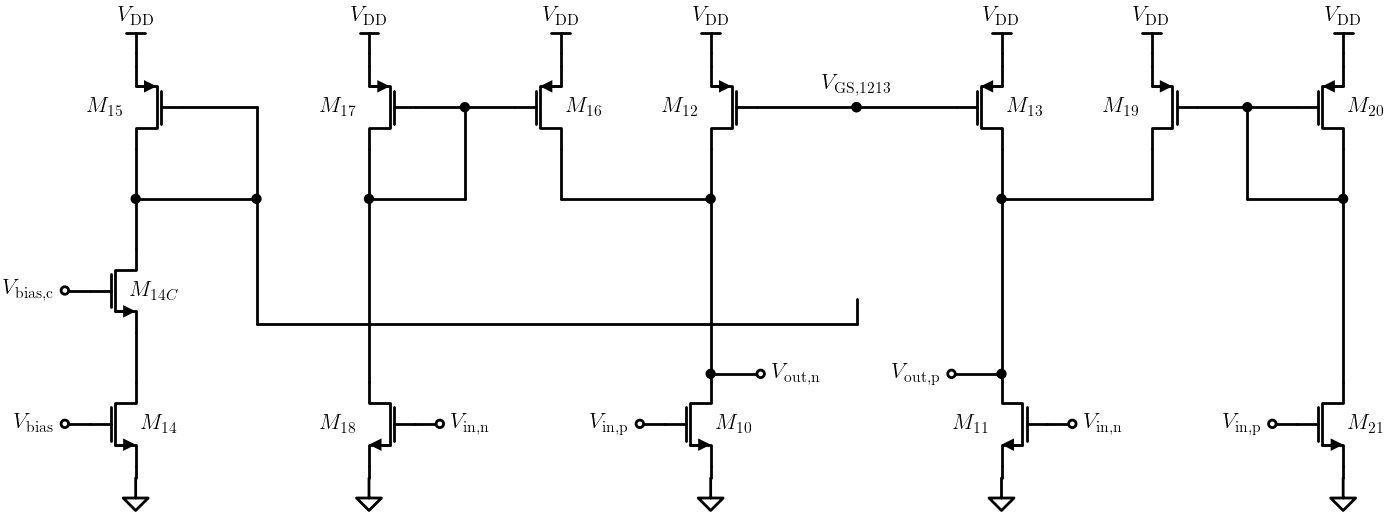

In [110]:
# Draw Push-Pull Output Stage without W/L
import matplotlib
matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "lmodern"
})
import schemdraw as sd
import schemdraw.elements as elm
sd.svgconfig.svg2 = False
with sd.Drawing() as d:
    d.config(unit=2)
    d.config(fontsize=16)
    
    # M14
    elm.Dot(open=True).label('$V_\mathrm{bias}$', loc='left', ofst=0.15)
    biasDot = d.here
    elm.Line().right().length(0.5)
    M14 = elm.AnalogNFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_{14}$', ofst=-1.75).reverse()
    elm.Line().at(M14.source).down().length(0.25)
    gndDot = d.here
    elm.GroundSignal()

    # M14c
    elm.Line().at(M14.drain).up().length(1)
    M14c = elm.AnalogNFet(offset_gate=False).anchor('source').theta(0).label(r'$M_{14C}$', ofst=-1.75).reverse()
    elm.Line().at(M14c.gate).left().length(0.5)
    elm.Dot(open=True).label('$V_\mathrm{bias,c}$', loc='left', ofst=0.15)
    biascDot = d.here

    # M15
    elm.Line().at(M14c.drain).up().length(1).dot()
    dot1 = d.here
    elm.Line().up().length(1)
    M15 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{15}$', ofst=0.25)
    elm.Line().at(M15.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M15.gate).right().length(1.5)
    elm.Line().down().toy(dot1).dot()
    d.push()
    elm.Line().left().tox(dot1)

    # M18
    elm.Dot(open=True).at((7.5, biasDot.y)).label('$V_\mathrm{in,n}$', loc='right', ofst=0.15)
    elm.Line().left().length(0.5)
    M18 = elm.AnalogNFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_{18}$', ofst=0.25)
    elm.Line().at(M18.source).down().toy(gndDot)
    elm.GroundSignal()

    # M17
    elm.Line().at(M18.drain).up().toy(dot1).dot()
    dot2 = d.here
    elm.Line().up().length(1)
    M17 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{17}$', ofst=0.25)
    elm.Line().at(M17.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M17.gate).right().length(1).dot()
    d.push()
    elm.Line().down().toy(dot2)
    elm.Line().left().tox(dot2)

    # M16
    d.pop()
    elm.Line().right().length(1)
    M16 = elm.AnalogPFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_{16}$', ofst=-1.75).reverse()
    elm.Line().at(M16.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M16.drain).down().toy(dot2)
    elm.Line().right().length(3).dot()
    d.push()

    # M12
    elm.Line().up().length(1)
    M12 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{12}$', ofst=0.25)
    elm.Line().at(M12.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M12.gate).right().length(2).dot()
    elm.Dot(open=False).label('$V_\mathrm{GS,1213}$', loc='top', ofst=0.15)
    dot3 = d.here
    
    # Voutn
    d.pop()
    elm.Line().down().length(3.5).dot()
    d.push()
    elm.Line().right().length(1)
    elm.Dot(open=True).label('$V_\mathrm{out,n}$', loc='right', ofst=0.15)
    d.pop()

    # M10
    elm.Line().down().toy(M18.drain)
    M10 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{10}$', ofst=-1.75).reverse()
    elm.Line().at(M10.gate).left().length(0.5)
    elm.Dot(open=True).label('$V_\mathrm{in,p}$', loc='left', ofst=0.15)
    elm.Line().at(M10.source).down().toy(gndDot)
    elm.GroundSignal()

    # M21
    elm.Dot(open=True).at((24.15, biasDot.y)).label('$V_\mathrm{in,p}$', loc='left', ofst=0.15)
    elm.Line().right().length(0.5)
    M21 = elm.AnalogNFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_{21}$', ofst=-1.75).reverse()
    elm.Line().at(M21.source).down().toy(gndDot)
    elm.GroundSignal()

    # M20
    elm.Line().at(M21.drain).up().toy(dot1).dot()
    dot4 = d.here
    elm.Line().up().length(1)
    M20 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{20}$', ofst=-1.75).reverse()
    elm.Line().at(M20.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M20.gate).left().length(1).dot()
    d.push()
    elm.Line().down().toy(dot4)
    elm.Line().right().tox(dot4)

    # M19
    d.pop()
    elm.Line().left().length(1)
    M19 = elm.AnalogPFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_{19}$', ofst=0.25)
    elm.Line().at(M19.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M19.drain).down().toy(dot2)
    elm.Line().left().length(3).dot()
    d.push()

    # M13
    elm.Line().up().length(1)
    M13 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{13}$', ofst=-1.75).reverse()
    elm.Line().at(M13.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M13.gate).left().tox(dot3)
    
    # Voutp
    d.pop()
    elm.Line().down().length(3.5).dot()
    d.push()
    elm.Line().left().length(1)
    elm.Dot(open=True).label('$V_\mathrm{out,p}$', loc='left', ofst=0.15)
    d.pop()

    # M11
    elm.Line().down().toy(M18.drain)
    M11 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{11}$', ofst=0.25)
    elm.Line().at(M11.gate).right().length(0.5)
    elm.Dot(open=True).label('$V_\mathrm{in,n}$', loc='right', ofst=0.15)
    elm.Line().at(M11.source).down().toy(gndDot)
    elm.GroundSignal()

    # Connection to CMFB
    d.pop()
    elm.Line().down().length(2.5)
    elm.Line().right().tox(dot3)
    elm.Line().up().length(0.5)

    # Save the schematic
    d.save('figures/amplifier_core/push_pull_output_stage_circuit.svg')
    d.save('figures/amplifier_core/push_pull_output_stage_circuit.pdf')

Specifications

In [111]:
# Define the given parameters as taken from the specification table or initial guesses

# Calculate voltages
Vds_m1213 = VDD - Vcm
Vds_m1011 = Vcm
print('Vds_m1213 =', round(float(Vds_m1213), 2), 'V')
print('Vds_m1011 =', round(float(Vds_m1011), 2), 'V \n')

# Set bias current per push-pull output stage

# Through M18 / M21 and M17 / M20 flows
i_m1821 = 50e-9
print('i_m1821 =', round(float(i_m1821) * 1e9, 2), 'nA')

# Through M12 / M13 flows
i_m1213 = i_m1821
print('i_m1213 =', round(float(i_m1213) * 1e9, 2), 'nA')

# This current is mirrored with factor e to common-source stage and flows through M10 / M12
e = 3
i_m1619 = e * i_m1821
print('i_m1619 =', round(float(i_m1619) * 1e9, 2), 'nA')

i_m1011 = i_m1213 + i_m1619
print('i_m1011 =', round(float(i_m1011) * 1e9, 2), 'nA')

print('total supply current of push-pull stage = i_m14 + 2 * (i_m1011 + i_m1821) =', round(float(i_m14 + 2 * (i_m1011 + i_m1821)) * 1e9, 1), 'nA \n')

# Set Bandwidth
f_1 = 0.15
f_2 = B

# Initial guess of gm/ID
# Maximize gm_m1011 for high gain and low vds,sat and minimize gm_m1213 (M12/M13 serves as a current source rather than a transconductor) for adequate gds but useable vds,sat.
# Vds,sat ~ 2 / (gm/ID)
# gm_id_1011 ~ gm_id_m1213 for symmetric output voltage swing.
# Decrease gm_id_m1011 if Vgs_m1011 is too small for the input stage (Vds_m34 = Vgs_m34 = Vgs_m1011)!
gm_id_m1213 = 14.7
print('gm_id_m1213 =', round(float(gm_id_m1213), 2), 'S/A')

gm_id_m1011 = 11.6
print('gm_id_m1011 =', round(float(gm_id_m1011), 2), 'S/A \n')

# Initial guess of L
l_1213 = 4 * 10
print('l_1213 =', round(float(l_1213), 2), 'um')

l_1011 = 4 * 10
print('l_1011 =', round(float(l_1011), 2), 'um')

# Connect / Disconnect additional Miller capacitance
miller_con = False
Cm = 100e-15

Vds_m1213 = 0.75 V
Vds_m1011 = 0.75 V 

i_m1821 = 50.0 nA
i_m1213 = 50.0 nA
i_m1619 = 150.0 nA
i_m1011 = 200.0 nA
total supply current of push-pull stage = i_m14 + 2 * (i_m1011 + i_m1821) = 531.0 nA 

gm_id_m1213 = 14.7 S/A
gm_id_m1011 = 11.6 S/A 

l_1213 = 40.0 um
l_1011 = 40.0 um


Look-up

In [112]:
# Look up parameters for chosen gm/ID and L

# Gate-Source Voltage for given L and gm/ID
Vgs_m1213 = lv_pmos.lookupVGS(GM_ID=gm_id_m1213, L=l_1213, VDS=Vds_m1213, VSB=0)
print('Vgs_m1213 =', round(float(Vgs_m1213), 2), 'V')
print('VDD - Vgs_m1213 =', round(float(VDD - Vgs_m1213), 2), 'V')

Vgs_m1011 = lv_nmos.lookupVGS(GM_ID=gm_id_m1011, L=l_1011, VDS=Vds_m1011, VSB=0)
print('Vgs_m1011 =', round(float(Vgs_m1011), 2), 'V \n')

# Vds,sat
Vds_sat_m1213 = 2 / gm_id_m1213
print('Vds_sat_m1213 =', round(float(Vds_sat_m1213), 2), 'V')

Vds_sat_m1011 = 2 / gm_id_m1011
print('Vds_sat_m1011 =', round(float(Vds_sat_m1011), 2), 'V \n')

# Transconductance (gm) from gm/ID and ID
gm_m1213 = i_m1213 * gm_id_m1213
print(f"gm_m1213 = {round(float(gm_m1213) * 1e6, 2)}uS")

gm_m1011 = i_m1011 * gm_id_m1011
print(f"gm_m1011 = {round(float(gm_m1011) * 1e6, 2)}uS \n")

# Output Conductance (gds)
gm_gds_m1213 = lv_pmos.lookup("GM_GDS", L=l_1213, VGS=Vgs_m1213, VDS=Vds_m1213, VSB=0)
gds_m1213 = gm_m1213 / gm_gds_m1213
print(f"gds_m1213 = {round(float(gds_m1213) * 1e9, 4)}nS (= {round(float(1/gds_m1213) * 1e-6, 2)}MOhm)")

gm_gds_m1011 = lv_nmos.lookup("GM_GDS", L=l_1011, VGS=Vgs_m1011, VDS=Vds_m1011, VSB=0)
gds_m1011 = gm_m1011 / gm_gds_m1011
print(f"gds_m1011 = {round(float(gds_m1011) * 1e9, 4)}nS (= {round(float(1/gds_m1011) * 1e-6, 2)}MOhm) \n")

# Cdd of M10 / M11
gm_Cdd_m1011 = lv_nmos.lookup("GM_CDD", L=l_1011, VGS=Vgs_m1011, VDS=Vds_m1011, VSB=0)
Cdd_m1011 = gm_m1011 / gm_Cdd_m1011
print(f"Cdd_m1011 = {round(float(Cdd_m1011) * 1e15, 2)} fF")

# Cgd of M10 / M11
gm_Cgd_m1011 = lv_nmos.lookup("GM_CGD", L=l_1011, VGS=Vgs_m1011, VDS=Vds_m1011, VSB=0)
Cgd_m1011 = gm_m1011 / gm_Cgd_m1011
print(f"Cgd_m1011 = {round(float(Cgd_m1011) * 1e15, 2)} fF")

# If additional Miller capacitance is connected in parallel:
if miller_con == True:
  Cgd_m1011 = Cgd_m1011 + Cm
  print(f"Cgd_m1011 + Cm = {round(float(Cgd_m1011) * 1e15, 2)} fF")

# Cgg of M10 / M11
gm_Cgg_m1011 = lv_nmos.lookup("GM_CGG", L=l_1011, VGS=Vgs_m1011, VDS=Vds_m1011, VSB=0)
Cgg_m1011 = gm_m1011 / gm_Cgg_m1011
print(f"Cgg_m1011 = {round(float(Cgg_m1011) * 1e15, 2)} fF \n")

# ID/W
id_W_m1213 = lv_pmos.lookup("ID_W", L=l_1213, VGS=Vgs_m1213, VDS=Vds_m1213, VSB=0)
w_1213 = i_m1213 / id_W_m1213
print(f"w_1213 = {round(float(w_1213), 2)} um ~ {round(float(w_1213), 1)} um (rounded)")

id_W_m1011 = lv_nmos.lookup("ID_W", L=l_1011, VGS=Vgs_m1011, VDS=Vds_m1011, VSB=0)
w_1011 = i_m1011 / id_W_m1011
print(f"w_1011 = {round(float(w_1011), 2)} um ~ {round(float(w_1011), 1)} um (rounded) \n")

# Gamma
sth_gm_m1213 = lv_pmos.lookup('STH_GM', L=l_1213, VGS=Vgs_m1213, VDS=Vds_m1213, VSB=0) # STH thermal noise psd at 1 Hz
sth_m1213 = sth_gm_m1213 * gm_m1213
gamma_m1213 = sth_m1213 / (4 * sc.k * T * gm_m1213)
print(f"gamma_m1213 = {round(float(gamma_m1213), 2)}")

sth_gm_m1011 = lv_nmos.lookup('STH_GM', L=l_1011, VGS=Vgs_m1011, VDS=Vds_m1011, VSB=0) # STH thermal noise psd at 1 Hz
sth_m1011 = sth_gm_m1011 * gm_m1011
gamma_m1011 = sth_m1011 / (4 * sc.k * T * gm_m1011)
print(f"gamma_m1011 = {round(float(gamma_m1011), 2)} \n")

# fco: flicker corner frequency @ flicker noise PSD = thermal noise PSD
fco_m1011 = lv_nmos.lookup('SFL_STH', L=l_1011, VGS=Vgs_m1011, VDS=Vds_m1011, VSB=0)
print(f"fco_m1011 = {round(float(fco_m1011), 2)} Hz")

fco_m1213 = lv_pmos.lookup('SFL_STH', L=l_1213, VGS=Vgs_m1213, VDS=Vds_m1213, VSB=0)
print(f"fco_m1213 = {round(float(fco_m1213), 2)} Hz \n")


Vgs_m1213 = 0.43 V
VDD - Vgs_m1213 = 1.07 V
Vgs_m1011 = 0.3 V 

Vds_sat_m1213 = 0.14 V
Vds_sat_m1011 = 0.17 V 

gm_m1213 = 0.73uS
gm_m1011 = 2.32uS 

gds_m1213 = 0.2752nS (= 3633.25MOhm)
gds_m1011 = 20.8765nS (= 47.9MOhm) 

Cdd_m1011 = 1.83 fF
Cgd_m1011 = 1.11 fF
Cgg_m1011 = 553.3 fF 

w_1213 = 4.02 um ~ 4.0 um (rounded)
w_1011 = 2.01 um ~ 2.0 um (rounded) 

gamma_m1213 = 1.37
gamma_m1011 = 0.75 

fco_m1011 = 590.35 Hz
fco_m1213 = 122.76 Hz 



Improving output voltage swing

In [113]:
# Sizing of M18 / M21

# Length of M18 / M21
l_1821 = l_1011
print(f"l_1821 = {round(float(l_1821), 2)} um ~ {round_to(float(l_1821), 5)} um (rounded)")

# Vgs of M18 / M21
Vgs_m1821 = Vgs_m1011
print('Vgs_m1821 =', round(float(Vgs_m1821), 2), 'V')

# Vds of M18 / M21
# Sets also W of M17 / M20
# If W of M17 / M20 is increased, then W of M16 / M19 is bigger and therefore rise and fall time equals the same (NMOS vs. PMOS).
# For example, Vds_m1821 = 0.84V sets w_m1720 = 0.5um and w_m1619 = 1.5um.
# Vds_m1821 = 0.94V sets w_m1720 = 1.0um and w_m1619 = 3.0um.
Vds_m1821 = 0.94
print('Vds_m1821 =', round(float(Vds_m1821), 2), 'V \n')

# ID of M18 / M21
print('i_m1821 =', round(float(i_m1821) * 1e9, 2), 'nA')

# gm / ID of M18 / M21
gm_id_m1821 = lv_nmos.lookup("GM_ID", L=l_1821, VGS=Vgs_m1821, VDS=Vds_m1821, VSB=0)
print('gm_id_m1821 =', round(float(gm_id_m1821), 2), 'S/A')

# Transconductance (gm) from gm/ID and ID of M18 / M21
gm_m1821 = i_m1821 * gm_id_m1821
print(f"gm_m1821 = {round(float(gm_m1821) * 1e6, 2)}uS")

# Output Conductance (gds) of M18 / M21
gm_gds_m1821 = lv_nmos.lookup("GM_GDS", L=l_1821, VGS=Vgs_m1821, VDS=Vds_m1821, VSB=0)
gds_m1821 = gm_m1821 / gm_gds_m1821
print(f"gds_m1821 = {round(float(gds_m1821) * 1e9, 4)}nS (= {round(float(1/gds_m1821) * 1e-6, 2)}MOhm)")

# ID/W of M18 / M21
id_W_m1821 = lv_nmos.lookup("ID_W", L=l_1821, VGS=Vgs_m1821, VDS=Vds_m1821, VSB=0)
w_1821 = i_m1821 / id_W_m1821
print(f"w_1821 = {round(float(w_1821), 2)} um ~ {round(float(w_1821), 1)} um (rounded)")

l_1821 = 40.0 um ~ 40 um (rounded)
Vgs_m1821 = 0.3 V
Vds_m1821 = 0.94 V 

i_m1821 = 50.0 nA
gm_id_m1821 = 11.54 S/A
gm_m1821 = 0.58uS
gds_m1821 = 4.4284nS (= 225.82MOhm)
w_1821 = 0.49 um ~ 0.5 um (rounded)


In [114]:
# Sizing of M17 / M20

# Length of M17 / M20
l_1720 = l_1213
print(f"l_1720 = {round(float(l_1720), 2)} um ~ {round_to(float(l_1720), 5)} um (rounded)")

# Vgs of M17 / M20 (Diode connected)
Vgs_m1720 = VDD - Vds_m1821
print('Vgs_m1720 = VDD - Vds_m1821 =', round(float(Vgs_m1720), 2), 'V')

# Vds of M17 / M20 (Diode connected)
Vds_m1720 = Vgs_m1720
print('Vds_m1720 = Vgs_m1720 =', round(float(Vds_m1720), 2), 'V \n')

# ID of M17 / M20
i_m1720 = i_m1821
print('i_m1720 =', round(float(i_m1720) * 1e9, 2), 'nA')

# gm / ID of M17 / M20
gm_id_m1720 = lv_pmos.lookup("GM_ID", L=l_1720, VGS=Vgs_m1720, VDS=Vds_m1720, VSB=0)
print('gm_id_m1720 =', round(float(gm_id_m1720), 2), 'S/A')

# Transconductance (gm) from gm/ID and ID of M17 / M20
gm_m1720 = i_m1720 * gm_id_m1720
print(f"gm_m1720 = {round(float(gm_m1720) * 1e6, 2)}uS")

# Output Conductance (gds) of M17 / M20
gm_gds_m1720 = lv_pmos.lookup("GM_GDS", L=l_1720, VGS=Vgs_m1720, VDS=Vds_m1720, VSB=0)
gds_m1720 = gm_m1720 / gm_gds_m1720
print(f"gds_m1720 = {round(float(gds_m1720) * 1e9, 4)}nS (= {round(float(1/gds_m1720) * 1e-6, 2)}MOhm)")

# ID/W of M17 / M20
id_W_m1720 = lv_pmos.lookup("ID_W", L=l_1720, VGS=Vgs_m1720, VDS=Vds_m1720, VSB=0)
w_1720 = i_m1720 / id_W_m1720
print(f"w_1720 = {round(float(w_1720), 2)} um ~ {round(float(w_1720), 1)} um (rounded)")

l_1720 = 40.0 um ~ 40 um (rounded)
Vgs_m1720 = VDD - Vds_m1821 = 0.56 V
Vds_m1720 = Vgs_m1720 = 0.56 V 

i_m1720 = 50.0 nA
gm_id_m1720 = 8.4 S/A
gm_m1720 = 0.42uS
gds_m1720 = 0.3545nS (= 2821.17MOhm)
w_1720 = 0.99 um ~ 1.0 um (rounded)


In [115]:
# Sizing of M16 / M19

# Length of M16 / M19
l_1619 = l_1213
print(f"l_1619 = {round(float(l_1619), 2)} um ~ {round_to(float(l_1619), 5)} um (rounded)")

# Vgs of M16 / M19
Vgs_m1619 = Vgs_m1720
print('Vgs_m1619 = Vgs_m1720 =', round(float(Vgs_m1619), 2), 'V')

# Vds of M16 / M19
Vds_m1619 = Vds_m1213
print('Vds_m1619 = Vds_m1213 =', round(float(Vds_m1619), 2), 'V \n')

# ID of M16 / M19
print('i_m1619 =', round(float(i_m1619) * 1e9, 2), 'nA')

# gm / ID of M16 / M19
gm_id_m1619 = lv_pmos.lookup("GM_ID", L=l_1619, VGS=Vgs_m1619, VDS=Vds_m1619, VSB=0)
print('gm_id_m1619 =', round(float(gm_id_m1619), 2), 'S/A')

# Transconductance (gm) from gm/ID and ID of M16 / M19
gm_m1619 = i_m1619 * gm_id_m1619
print(f"gm_m1619 = {round(float(gm_m1619) * 1e6, 2)}uS")

# Output Conductance (gds) of M16 / M19
gm_gds_m1619 = lv_pmos.lookup("GM_GDS", L=l_1619, VGS=Vgs_m1619, VDS=Vds_m1619, VSB=0)
gds_m1619 = gm_m1619 / gm_gds_m1619
print(f"gds_m1619 = {round(float(gds_m1619) * 1e9, 4)}nS (= {round(float(1/gds_m1619) * 1e-6, 2)}MOhm)")

# ID/W of M16 / M19
id_W_m1619 = lv_pmos.lookup("ID_W", L=l_1619, VGS=Vgs_m1619, VDS=Vds_m1619, VSB=0)
w_1619 = i_m1619 / id_W_m1619
print(f"w_1619 = {round(float(w_1619), 2)} um ~ {round(float(w_1619), 1)} um (rounded)")

l_1619 = 40.0 um ~ 40 um (rounded)
Vgs_m1619 = Vgs_m1720 = 0.56 V
Vds_m1619 = Vds_m1213 = 0.75 V 

i_m1619 = 150.0 nA
gm_id_m1619 = 8.4 S/A
gm_m1619 = 1.26uS
gds_m1619 = 0.7161nS (= 1396.47MOhm)
w_1619 = 2.98 um ~ 3.0 um (rounded)


Sizing of bias circuit

In [116]:
# Sizing of NMOS M14 / M14c
# From the bias circuit (see sizing_bias_circuit.ipynb) we get the Gate-Source voltages for M14 / M14c
Vgs_m14c = Vbiasc
print(f"Vgs_m14c = {round(float(Vgs_m14c), 3)} V")

Vgs_m14 = Vbias
print(f"Vgs_m14 = {round(float(Vgs_m14), 3)} V")

# i_m14 should be a multiple (a) of Ibias
a = 2.5
i_m14 = a * Ibias
print(f"i_m14 = {a} * Ibias = {round(float(i_m14) * 1e9, 2)} nA \n")

# Since the the W/L ratios of the NMOS cascode M2 / M2c in the BMR are known (see sizing_bias_circuit.ipynb), 
# the W/L ratio of the biasing cascode can be calculated for a given current.
# (W/L)2/2c = a * (W/L)14/14c
l_14c = l_mxc
print(f"l_14c = {round(float(l_14c), 2)} um ~ {round_to(float(l_14c), 5)} um (rounded)")

l_14 = l_mx
print(f"l_14 = {round(float(l_14), 2)} um ~ {round_to(float(l_14), 5)} um (rounded)")

w_14c = a * w_mxc
print(f"w_14c = {round(float(w_14c), 2)} um ~ {round(float(w_14c), 1)} um (rounded)")

w_14 = a * w_mx
print(f"w_14 = {round(float(w_14), 2)} um ~ {round(float(w_14), 1)} um (rounded)")

Vgs_m14c = 0.207 V
Vgs_m14 = 0.101 V
i_m14 = 2.5 * Ibias = 25.0 nA 

l_14c = 20.0 um ~ 20 um (rounded)
l_14 = 20.0 um ~ 20 um (rounded)
w_14c = 12.5 um ~ 12.5 um (rounded)
w_14 = 12.5 um ~ 12.5 um (rounded)


In [117]:
# Sizing of PMOS M15
# M15 only mirrors the current to the current-source of the push-pull amplifier.
# L is the same length as M12 / M13.
l_15 = l_1213
print(f"l_15 = {round(float(l_15), 2)} um ~ {round_to(float(l_15), 5)} um (rounded)")

# w_15 depends on the current through M14 and the common-source amplifier quiescent current.
i_ratio_cs = i_m1213 / i_m14
print(f"i_ratio_cs = {round(float(i_ratio_cs), 2)}")

w_15 = w_1213 / i_ratio_cs
print(f"w_15 = {round(float(w_15), 2)} um ~ {round(float(w_15), 1)} um (rounded)")

l_15 = 40.0 um ~ 40 um (rounded)
i_ratio_cs = 2.0
w_15 = 2.01 um ~ 2.0 um (rounded)


Open-loop gain

In [118]:
# Calculate open-loop gain of push-pull output stage without R_2_CMFB (SC CMFB)
A_ol_0_pp_wo_R = 2 * (gm_m1821 + gm_m1011) / 2 / (gds_m1011 + gds_m1213 + gds_m1619)
A_ol_0_pp_wo_R_dB = 20 * np.log10(A_ol_0_pp_wo_R)
print('A_ol_0_pp_wo_R =', round(float(A_ol_0_pp_wo_R), 2), '/', round(float(A_ol_0_pp_wo_R_dB), 2), 'dB without R_2_CMFB (SC CMFB)')

# Calculate open-loop gain of push-pull output stage with R_2_CMFB
A_ol_0_pp = 2 * (gm_m1821 + gm_m1011) / 2 / (gds_m1011 + gds_m1213 + gds_m1619 + 1 / R_2_CMFB)
A_ol_0_pp_dB = 20 * np.log10(A_ol_0_pp)
print('A_ol_0_pp =', round(float(A_ol_0_pp), 2), '/', round(float(A_ol_0_pp_dB), 2), 'dB with R_2_CMFB =', round(float(R_2_CMFB) * 1e-6, 2), 'MOhm')

# Conclusion:
# Push-Pull stage increases the open-loop gain compared to the common-source stage as expected.
# Furthermore, the SC CMFB again increases the gain compared to the resistor CMFB with R_2_CMFB.

A_ol_0_pp_wo_R = 132.48 / 42.44 dB without R_2_CMFB (SC CMFB)
A_ol_0_pp = 47.38 / 33.51 dB with R_2_CMFB = 25.46 MOhm


Summarize results

In [119]:
# Print out final design values
Vgs_m1011_final = Vgs_m1011

print('Push-pull output stage dimensioning:')
print('-----------------------------------------------')
print('M12/13: W =', round(w_1213, 1), 'um, L =', l_1213, 'um')
print('M10/11: W =', round(w_1011, 1), 'um, L =', l_1011, 'um')

print('M16/19: W =', round(w_1619, 1), 'um, L =', l_1619, 'um')
print('M17/20: W =', round(w_1720, 1), 'um, L =', l_1720, 'um')
print('M18/21: W =', round(w_1821, 1), 'um, L =', l_1821, 'um')
print()
print('Push-pull output stage biasing dimensioning:')
print('-----------------------------------------------')
print('M15: W =', round(w_15, 1), 'um, L =', l_15, 'um')
print('M14 / M14c: W =', round(w_14, 2), 'um, L =', l_14, 'um')
print()
print('Push-pull output stage performance summary:')
print('-----------------------------------------------')
print('Vgs_m1011 = Vgs_m1821 =', round(float(Vgs_m1011), 1), 'V')
print('Ibias = i_m14 =', round(float(i_m14) * 1e9, 1), 'nA')
print('i_m1821 =', round(float(i_m1821) * 1e9, 1), 'nA')
print('i_m1619 =', round(float(i_m1619) * 1e9, 1), 'nA')
print('i_m1213 =', round(float(i_m1213) * 1e9, 1), 'nA')
print('i_m1011 =', round(float(i_m1011) * 1e9, 1), 'nA')
print('total supply current of push-pull stage = i_m14 + 2 * (i_m1011 + i_m1821) =', round(float(i_m14 + 2 * (i_m1011 + i_m1821)) * 1e9, 1), 'nA')
print('A_ol_0_pp_wo_R =', round(float(A_ol_0_pp_wo_R), 2), '/', round(float(A_ol_0_pp_wo_R_dB), 2), 'dB without R_2_CMFB (SC CMFB)')
print('A_ol_0_pp =', round(float(A_ol_0_pp), 2), '/', round(float(A_ol_0_pp_dB), 2), 'dB with R_2_CMFB =', round(float(R_2_CMFB) * 1e-6, 2), 'MOhm')
print('-----------------------------------------------')

Push-pull output stage dimensioning:
-----------------------------------------------
M12/13: W = 4.0 um, L = 40 um
M10/11: W = 2.0 um, L = 40 um
M16/19: W = 3.0 um, L = 40 um
M17/20: W = 1.0 um, L = 40 um
M18/21: W = 0.5 um, L = 40 um

Push-pull output stage biasing dimensioning:
-----------------------------------------------
M15: W = 2.0 um, L = 40 um
M14 / M14c: W = 12.5 um, L = 20 um

Push-pull output stage performance summary:
-----------------------------------------------
Vgs_m1011 = Vgs_m1821 = 0.3 V
Ibias = i_m14 = 25.0 nA
i_m1821 = 50.0 nA
i_m1619 = 150.0 nA
i_m1213 = 50.0 nA
i_m1011 = 200.0 nA
total supply current of push-pull stage = i_m14 + 2 * (i_m1011 + i_m1821) = 525.0 nA
A_ol_0_pp_wo_R = 132.48 / 42.44 dB without R_2_CMFB (SC CMFB)
A_ol_0_pp = 47.38 / 33.51 dB with R_2_CMFB = 25.46 MOhm
-----------------------------------------------


Simulation with idealized CMFB (R_2_CMFB)

In [120]:
# In the final circuit stacked transistors are used. 
# With the BMR circuit, the stacked transistors, the body effect increases and therefore Vgs_m1011 changes slightly.
# The final values obtained during simulation are:

# Width of M14 / M14c and M15 changed from 12.5um to 11.5um and from 2.0um to 6.0um, respectively, to set Vcm to 0.75V at the output.
# This is due to the resistors. For a SC CMFB, w_15 will be changed back to 2.0um.
# If w_15 is decreased, Vcm is increased.
# If w_14 is decreased, Vcm is decreased.
w_15 = 12 * 0.5
w_14 = 23 * 0.5
Vgs_m1011 = 0.345

# Print out final design values
print('Push-pull output stage dimensioning:')
print('-----------------------------------------------')
print('M12/13: W =', round(w_1213, 1), 'um, L =', l_1213, 'um')
print('M10/11: W =', round(w_1011, 1), 'um, L =', l_1011, 'um')

print('M16/19: W =', round(w_1619, 1), 'um, L =', l_1619, 'um')
print('M17/20: W =', round(w_1720, 1), 'um, L =', l_1720, 'um')
print('M18/21: W =', round(w_1821, 1), 'um, L =', l_1821, 'um')
print()
print('Push-pull output stage biasing dimensioning:')
print('-----------------------------------------------')
print('M15: W =', round(w_15, 1), 'um, L =', l_15, 'um')
print('M14 / M14c: W =', round(w_14, 2), 'um, L =', l_14, 'um')
print()
print('Push-pull output stage performance summary:')
print('-----------------------------------------------')
print('Vgs_m1011 = Vgs_m1821 =', round(float(Vgs_m1011), 4), 'V')
print('Ibias = i_m14 =', round(float(i_m14) * 1e9, 1), 'nA')
print('i_m1821 =', round(float(i_m1821) * 1e9, 1), 'nA')
print('i_m1619 =', round(float(i_m1619) * 1e9, 1), 'nA')
print('i_m1213 =', round(float(i_m1213) * 1e9, 1), 'nA')
print('i_m1011 = i_m1619 + i_m1213 =', round(float(i_m1011) * 1e9, 1), 'nA')
print('total supply current of push-pull stage = i_m14 + 2 * (i_m1011 + i_m1821) =', round(float(25.04 + 2 * (200.17 + 50.55)), 1), 'nA')
print('total supply current of push-pull stage (enable down) =', round(float(326 + 2 * (48 + 11)), 1), 'pA')
print(f"vout_pp = vout_pp_max - vout_pp_min (linear) = {round(float(1.3), 2)} - {round(float(0.2), 2)} = {round(float(1.3-0.2), 2)} V at VDD = {round(float(VDD), 2)} V")
print(f"vout_pp = vout_pp_max - vout_pp_min = {round(float(1.46), 2)} - {round(float(0.03), 2)} = {round(float(1.46-0.03), 2)} V at VDD = {round(float(VDD), 2)} V")
print('A_ol_0_pp =', round(float(38.15), 2), 'dB with R_2_CMFB =', round(float(R_2_CMFB) * 1e-6, 2), 'MOhm')
print('f_c_pp =', round(float(1.74), 2), 'kHz with R_2_CMFB =', round(float(R_2_CMFB) * 1e-6, 2), 'MOhm and C_L_tot_max =', round(float(C_L_tot_max * 1e12), 2), 'pF')
print('Phase Margin =', round(float(108.98), 2), '°')
print('GBWP_pp = A_ol_0_pp * f_c_pp =', round(float(99.64), 2), 'kHz = f_u_pp')
print('f_z_pp ~', round(float(20), 2), 'MHz')
print('input-referred noise from 0.15 to', round(B, 2), 'Hz =', round(10.93, 1), 'uVrms')
print('output-referred noise from 0.15 to', round(B, 2), 'Hz =', round(880, 1), 'uVrms')
print('input-referred noise from 0.30 to', round(B, 2), 'Hz =', round(10.51, 1), 'uVrms')
print('output-referred noise from 0.30 to', round(B, 2), 'Hz =', round(846, 1), 'uVrms')
print('rising and falling slewing time ~', round(5, 2), 'us') # Since M16 / M19 is a little wider than M10 / M11.
print('-----------------------------------------------')

Push-pull output stage dimensioning:
-----------------------------------------------
M12/13: W = 4.0 um, L = 40 um
M10/11: W = 2.0 um, L = 40 um
M16/19: W = 3.0 um, L = 40 um
M17/20: W = 1.0 um, L = 40 um
M18/21: W = 0.5 um, L = 40 um

Push-pull output stage biasing dimensioning:
-----------------------------------------------
M15: W = 6.0 um, L = 40 um
M14 / M14c: W = 11.5 um, L = 20 um

Push-pull output stage performance summary:
-----------------------------------------------
Vgs_m1011 = Vgs_m1821 = 0.345 V
Ibias = i_m14 = 25.0 nA
i_m1821 = 50.0 nA
i_m1619 = 150.0 nA
i_m1213 = 50.0 nA
i_m1011 = i_m1619 + i_m1213 = 200.0 nA
total supply current of push-pull stage = i_m14 + 2 * (i_m1011 + i_m1821) = 526.5 nA
total supply current of push-pull stage (enable down) = 444.0 pA
vout_pp = vout_pp_max - vout_pp_min (linear) = 1.3 - 0.2 = 1.1 V at VDD = 1.5 V
vout_pp = vout_pp_max - vout_pp_min = 1.46 - 0.03 = 1.43 V at VDD = 1.5 V
A_ol_0_pp = 38.15 dB with R_2_CMFB = 25.46 MOhm
f_c_pp = 1.74 

Simulation with SC CMFB

In [121]:
# Replacing the idealized CMFB with resistors with the switched-capacitor CMFB also changes some values.
# The final values obtained during simulation are:

# Width of M15 changed from 6.0um back to 2.0um as calculated, to set Vcm to 0.75V at the output.
# Width of M14 / M14c is not changed.
w_15 = 4 * 0.5

w_1213 = round(w_1213, 1)
w_1011 = round(w_1011, 1)
w_1619 = round(w_1619, 1)
w_1720 = round(w_1720, 1)
w_1821 = round(w_1821, 1)
w_15 = round(w_15, 1)
w_14 = round(w_14, 2)

# Print out final design values
print('Push-pull output stage dimensioning:')
print('-----------------------------------------------')
print('M12/13: W =', round(w_1213, 1), 'um, L =', l_1213, 'um')
print('M10/11: W =', round(w_1011, 1), 'um, L =', l_1011, 'um')

print('M16/19: W =', round(w_1619, 1), 'um, L =', l_1619, 'um')
print('M17/20: W =', round(w_1720, 1), 'um, L =', l_1720, 'um')
print('M18/21: W =', round(w_1821, 1), 'um, L =', l_1821, 'um')
print()
print('Push-pull output stage biasing dimensioning:')
print('-----------------------------------------------')
print('M15: W =', round(w_15, 1), 'um, L =', l_15, 'um')
print('M14 / M14c: W =', round(w_14, 2), 'um, L =', l_14, 'um')
print()
print('Push-pull output stage performance summary:')
print('-----------------------------------------------')
print('A_ol_0_pp =', round(float(44.74), 2), 'dB without R_2_CMFB (SC CMFB)')
print('rising and falling slewing time ~', round(7.5, 2), 'us') # Since M16 / M19 is a little wider than M10 / M11.
print('-----------------------------------------------')

Push-pull output stage dimensioning:
-----------------------------------------------
M12/13: W = 4.0 um, L = 40 um
M10/11: W = 2.0 um, L = 40 um
M16/19: W = 3.0 um, L = 40 um
M17/20: W = 1.0 um, L = 40 um
M18/21: W = 0.5 um, L = 40 um

Push-pull output stage biasing dimensioning:
-----------------------------------------------
M15: W = 2.0 um, L = 40 um
M14 / M14c: W = 11.5 um, L = 20 um

Push-pull output stage performance summary:
-----------------------------------------------
A_ol_0_pp = 44.74 dB without R_2_CMFB (SC CMFB)
rising and falling slewing time ~ 7.5 us
-----------------------------------------------


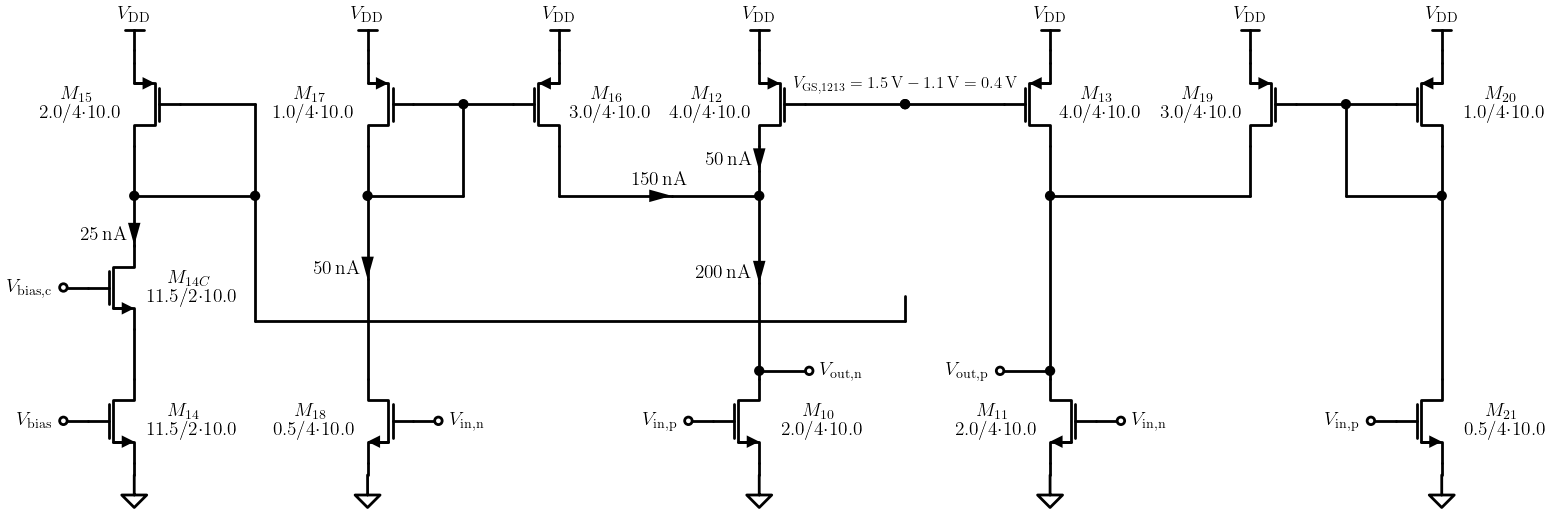

In [122]:
# Draw Push-Pull Output Stage with W/L
import matplotlib
matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "lmodern"
})
import schemdraw as sd
import schemdraw.elements as elm
sd.svgconfig.svg2 = False
with sd.Drawing() as d:
    d.config(unit=2)
    d.config(fontsize=14)
    
    # M14
    elm.Dot(open=True).label('$V_\mathrm{bias}$', loc='left', ofst=0.15)
    biasDot = d.here
    elm.Line().right().length(0.5)
    M14 = elm.AnalogNFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_{14} \\$'+str(w_14/1.0)+'/'+r'$2 \cdot$'+str(l_14/2.0), ofst=-3.0).reverse()
    elm.Line().at(M14.source).down().length(0.25)
    gndDot = d.here
    elm.GroundSignal()

    # M14c
    elm.Line().at(M14.drain).up().length(1)
    M14c = elm.AnalogNFet(offset_gate=False).anchor('source').theta(0).label(r'$M_{14C} \\$'+str(w_14/1.0)+'/'+r'$2 \cdot$'+str(l_14/2.0), ofst=-3.0).reverse()
    elm.Line().at(M14c.gate).left().length(0.5)
    elm.Dot(open=True).label('$V_\mathrm{bias,c}$', loc='left', ofst=0.15)
    biascDot = d.here

    # M15
    elm.Line().at(M14c.drain).up().length(0.01)
    elm.Arrowhead(headwidth=0.25, headlength=0.45).label(r'25\,nA', loc='top', ofst=-0.1).reverse()
    elm.Line().up().length(0.99).dot()
    dot1 = d.here
    elm.Line().up().length(1)
    M15 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{15} \\$'+str(w_15/1.0)+'/'+r'$4 \cdot$'+str(l_15/4.0), ofst=0.25)
    elm.Line().at(M15.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M15.gate).right().length(1.5)
    elm.Line().down().toy(dot1).dot()
    d.push()
    elm.Line().left().tox(dot1)

    # M18
    elm.Dot(open=True).at((7.5, biasDot.y)).label('$V_\mathrm{in,n}$', loc='right', ofst=0.15)
    elm.Line().left().length(0.5)
    M18 = elm.AnalogNFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_{18} \\$'+str(w_1821/1.0)+'/'+r'$4 \cdot$'+str(l_1821/4.0), ofst=0.25)
    elm.Line().at(M18.source).down().toy(gndDot)
    elm.GroundSignal()

    # M17
    elm.Line().at(M18.drain).up().length(2)
    elm.Arrowhead(headwidth=0.25, headlength=0.45).label(r'50\,nA', loc='top', ofst=-0.1).reverse()
    elm.Line().up().toy(dot1).dot()
    dot2 = d.here
    elm.Line().up().length(1)
    M17 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{17} \\$'+str(w_1720/1.0)+'/'+r'$4 \cdot$'+str(l_1720/4.0), ofst=0.25)
    elm.Line().at(M17.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M17.gate).right().length(1).dot()
    d.push()
    elm.Line().down().toy(dot2)
    elm.Line().left().tox(dot2)

    # M16
    d.pop()
    elm.Line().right().length(1)
    M16 = elm.AnalogPFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_{16} \\$'+str(w_1619/1.0)+'/'+r'$4 \cdot$'+str(l_1619/4.0), ofst=-2.75).reverse()
    elm.Line().at(M16.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M16.drain).down().toy(dot2)
    elm.Line().right().length(2.25)
    elm.Arrowhead(headwidth=0.25, headlength=0.45).label(r'150\,nA', loc='top', ofst=-0.1)
    elm.Line().right().length(1.75).dot()
    d.push()

    # M12
    elm.Line().up().length(0.50)
    elm.Arrowhead(headwidth=0.25, headlength=0.45).label(r'50\,nA', loc='top', ofst=-0.1).reverse()
    elm.Line().up().length(0.50)
    M12 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{12} \\$'+str(w_1213/1.0)+'/'+r'$4 \cdot$'+str(l_1213/4.0), ofst=0.15)
    elm.Line().at(M12.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M12.gate).right().length(2).dot()
    elm.Dot(open=False).label(r'$V_\mathrm{GS,1213} = 1.5\,\textrm{V} - 1.1\,\textrm{V} = 0.4\,\textrm{V}$', loc='top', ofst=0.15, fontsize=12)
    dot3 = d.here
    
    # Voutn
    d.pop()
    elm.Line().down().length(1.75)
    elm.Arrowhead(headwidth=0.25, headlength=0.45).label(r'200\,nA', loc='top', ofst=-0.1)
    elm.Line().down().length(1.75).dot()
    d.push()
    elm.Line().right().length(1)
    elm.Dot(open=True).label('$V_\mathrm{out,n}$', loc='right', ofst=0.15)
    d.pop()

    # M10
    elm.Line().down().toy(M18.drain)
    M10 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{10} \\$'+str(w_1011/1.0)+'/'+r'$4 \cdot$'+str(l_1011/4.0), ofst=-3.0).reverse()
    elm.Line().at(M10.gate).left().length(0.5)
    elm.Dot(open=True).label('$V_\mathrm{in,p}$', loc='left', ofst=0.15)
    elm.Line().at(M10.source).down().toy(gndDot)
    elm.GroundSignal()

    # M21
    elm.Dot(open=True).at((26.15, biasDot.y)).label('$V_\mathrm{in,p}$', loc='left', ofst=0.15)
    elm.Line().right().length(0.5)
    M21 = elm.AnalogNFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_{21} \\$'+str(w_1821/1.0)+'/'+r'$4 \cdot$'+str(l_1821/4.0), ofst=-3.0).reverse()
    elm.Line().at(M21.source).down().toy(gndDot)
    elm.GroundSignal()

    # M20
    elm.Line().at(M21.drain).up().toy(dot1).dot()
    dot4 = d.here
    elm.Line().up().length(1)
    M20 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{20} \\$'+str(w_1720/1.0)+'/'+r'$4 \cdot$'+str(l_1720/4.0), ofst=-3.0).reverse()
    elm.Line().at(M20.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M20.gate).left().length(1).dot()
    d.push()
    elm.Line().down().toy(dot4)
    elm.Line().right().tox(dot4)

    # M19
    d.pop()
    elm.Line().left().length(1)
    M19 = elm.AnalogPFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_{19} \\$'+str(w_1619/1.0)+'/'+r'$4 \cdot$'+str(l_1619/4.0), ofst=0.15)
    elm.Line().at(M19.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M19.drain).down().toy(dot2)
    elm.Line().left().length(4).dot()
    d.push()

    # M13
    elm.Line().up().length(1)
    M13 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{13} \\$'+str(w_1213/1.0)+'/'+r'$4 \cdot$'+str(l_1213/4.0), ofst=-2.75).reverse()
    elm.Line().at(M13.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    elm.Line().at(M13.gate).left().tox(dot3)
    
    # Voutp
    d.pop()
    elm.Line().down().length(3.5).dot()
    d.push()
    elm.Line().left().length(1)
    elm.Dot(open=True).label('$V_\mathrm{out,p}$', loc='left', ofst=0.15)
    d.pop()

    # M11
    elm.Line().down().toy(M18.drain)
    M11 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{11} \\$'+str(w_1011/1.0)+'/'+r'$4 \cdot$'+str(l_1011/4.0), ofst=0.25)
    elm.Line().at(M11.gate).right().length(0.5)
    elm.Dot(open=True).label('$V_\mathrm{in,n}$', loc='right', ofst=0.15)
    elm.Line().at(M11.source).down().toy(gndDot)
    elm.GroundSignal()

    # Connection to CMFB
    d.pop()
    elm.Line().down().length(2.5)
    elm.Line().right().tox(dot3)
    elm.Line().up().length(0.5)

    # Save the schematic
    d.save('figures/amplifier_core/push_pull_output_stage_WL_circuit.svg')
    d.save('figures/amplifier_core/push_pull_output_stage_WL_circuit.pdf')

## Sizing of Telescopic Input Stage

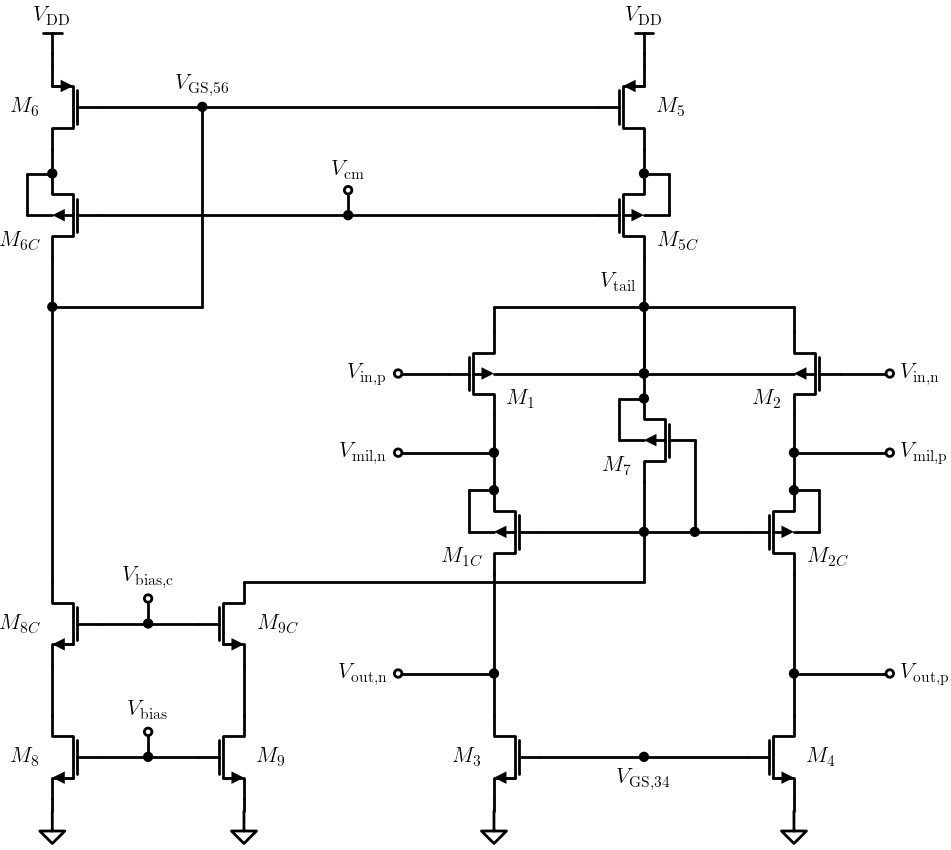

In [123]:
# Draw Telescopic Input Stage without W/L
import matplotlib
matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "lmodern"
})
import schemdraw as sd
import schemdraw.elements as elm
sd.svgconfig.svg2 = False
with sd.Drawing() as d:
    d.config(unit=2)
    d.config(fontsize=16)
    
    # Vbias
    elm.Dot(open=True).label('$V_\mathrm{bias}$', loc='top', ofst=0.15)
    elm.Line().down().length(0.5).dot()
    d.push()
    elm.Line().left().length(1)

    # M8
    M8 = elm.AnalogNFet(offset_gate=False).anchor('gate').theta(0).label('$M_8$', ofst=0.25)
    elm.Line().at(M8.source).down().length(0.25)
    gndDot = d.here
    elm.GroundSignal()
    elm.Line().at(M8.drain).up().length(1)

    # M8c
    M8c = elm.AnalogNFet(offset_gate=False).anchor('source').theta(0).label(r'$M_{8C}$', ofst=0.25)
    elm.Line().at(M8c.gate).right().length(1).dot()
    d.push()
    elm.Line().up().length(0.5)
    elm.Dot(open=True).label('$V_\mathrm{bias,c}$', loc='top', ofst=0.15)
    d.pop()
    elm.Line().right().length(1)

    # M9
    d.pop()
    elm.Line().right().length(1)
    M9 = elm.AnalogNFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_{9}$', ofst=-1.75).reverse()
    elm.Line().at(M9.source).down().toy(gndDot)
    elm.GroundSignal()

    # M9c
    elm.Line().at(M9.drain).up().length(1)
    M9c = elm.AnalogNFet(offset_gate=False).anchor('source').theta(0).label(r'$M_{9C}$', ofst=-2.0).reverse()

    # High-Swing Current Mirror
    # M6c
    elm.Line().at(M8c.drain).up().length(5.5).dot()
    d.push()
    elm.Line().up().length(1)
    M6c = elm.AnalogPFet(offset_gate=False, bulk=True).anchor('drain').theta(0).label(r'$M_{6C}$', ofst=(-0.25, -0.5))
    elm.Line().at(M6c.bulk).left().length(0.5)
    elm.Line().up().toy(M6c.source)
    elm.Line().right().tox(M6c.source).dot()
    elm.Line().at(M6c.gate).right().length(5).dot()
    d.push()
    elm.Line().up().length(0.5)
    elm.Dot(open=True).label('$V_\mathrm{cm}$', loc='top', ofst=0.15)
    d.pop()
    elm.Line().right().length(5)

    # M5c
    M5c = elm.AnalogPFet(offset_gate=False, bulk=True).anchor('gate').theta(0).label(r'$M_{5C}$', ofst=(2.0, -0.5)).reverse()
    elm.Line().at(M5c.bulk).right().length(0.5)
    elm.Line().up().toy(M5c.source)
    elm.Line().left().tox(M5c.source).dot()

    # M5
    elm.Line().at(M5c.source).up().length(0.5)
    M5 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{5}$', ofst=-1.75).reverse()
    elm.Line().at(M5.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)

    # M6
    elm.Line().at(M6c.source).up().length(0.5)
    M6 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{6}$', ofst=0.25)
    elm.Line().at(M6.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    d.pop()
    elm.Line().right().length(3)
    elm.Line().up().toy(M6.gate)
    elm.Dot(open=False).label('$V_\mathrm{GS,56}$', loc='top', ofst=0.15)
    d.push()
    elm.Line().left().tox(M6.gate)
    d.pop()
    elm.Line().right().tox(M5.gate)

    # Diff. Pair
    elm.Line().at(M5c.drain).down().length(1)
    elm.Dot(open=False).label('$V_\mathrm{tail}$', loc='bottom', ofst=(-0.50, 0.75))
    tailDot = d.here
    d.push()

    # M1
    elm.Line().left().length(3.0)
    elm.Line().down().length(0.5)
    M1 = elm.AnalogPFet(offset_gate=False, bulk=True).anchor('source').theta(0).label(r'$M_{1}$', ofst=(1.75, -0.5)).reverse()
    elm.Line().at(M1.bulk).right().tox(tailDot).dot()
    elm.Line().up().toy(tailDot)
    elm.Line().at(M1.gate).left().length(1)
    elm.Dot(open=True).label('$V_\mathrm{in,p}$', loc='left', ofst=0.15)
    vinpDot = d.here

    # M2
    d.pop()
    elm.Line().right().length(3.0)
    elm.Line().down().length(0.5)
    M2 = elm.AnalogPFet(offset_gate=False, bulk=True).anchor('source').theta(0).label(r'$M_{2}$', ofst=(-0.25, -0.5))
    elm.Line().at(M2.bulk).left().tox(tailDot).dot()
    elm.Line().up().toy(tailDot)
    elm.Line().at(M2.gate).right().length(1)
    elm.Dot(open=True).label('$V_\mathrm{in,n}$', loc='right', ofst=0.15)
    vinnDot = d.here

    # Vmiln
    elm.Line().at(M1.drain).down().length(0.75).dot()
    d.push()
    elm.Line().left().tox(vinpDot)
    elm.Dot(open=True).label('$V_\mathrm{mil,n}$', loc='left', ofst=0.15)
    d.pop()
    elm.Line().down().length(0.75)

    # M1c
    M1c = elm.AnalogPFet(offset_gate=False, bulk=True).anchor('source').theta(0).label(r'$M_{1C}$', ofst=(-0.25, -0.5))
    elm.Line().at(M1c.bulk).left().length(0.5)
    elm.Line().up().toy(M1c.source)
    elm.Line().right().tox(M1c.source).dot()

    # M7
    elm.Line().at(M1c.gate).right().tox(tailDot).dot()
    elm.Line().up().length(1)
    M7 = elm.AnalogPFet(offset_gate=False, bulk=True).anchor('drain').theta(0).label(r'$M_{7}$', ofst=(-0.25, -0.5))
    elm.Line().at(M7.source).toy(M1.bulk)
    elm.Line().at(M7.bulk).left().length(0.5)
    elm.Line().up().toy(M7.source)
    elm.Line().right().tox(M7.source).dot()
    elm.Line().at(M7.gate).right().length(0.1)
    elm.Line().down().toy(M1c.gate).dot()

    # Vmilp
    elm.Line().at(M2.drain).down().length(0.75).dot()
    d.push()
    elm.Line().right().tox(vinnDot)
    elm.Dot(open=True).label('$V_\mathrm{mil,p}$', loc='right', ofst=0.15)
    d.pop()
    elm.Line().down().length(0.75)

    # M2c
    M2c = elm.AnalogPFet(offset_gate=False, bulk=True).anchor('source').theta(0).label(r'$M_{2C}$', ofst=(2.0, -0.5)).reverse()
    elm.Line().at(M2c.bulk).right().length(0.5)
    elm.Line().up().toy(M2c.source)
    elm.Line().left().tox(M2c.source).dot()
    elm.Line().at(M2c.gate).left().tox(M7.drain)

    # Connection to M9c
    elm.Line().down().length(1.0)
    elm.Line().left().tox(M9c.drain)
    elm.Line().down().toy(M9c.drain)

    # Voutn
    elm.Line().at(M1c.drain).down().length(2.0).dot()
    d.push()
    elm.Line().left().tox(vinpDot)
    elm.Dot(open=True).label('$V_\mathrm{out,n}$', loc='left', ofst=0.15)
    d.pop()

    # M3
    elm.Line().down().toy(M9.drain)
    M3 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{3}$', ofst=0.25)
    elm.Line().at(M3.gate).right().tox(tailDot)
    elm.Dot(open=False).label('$V_\mathrm{GS,34}$', loc='bottom', ofst=0.15)
    elm.Line().at(M3.source).down().toy(gndDot)
    elm.GroundSignal()

    # Voutp
    elm.Line().at(M2c.drain).down().length(2.0).dot()
    d.push()
    elm.Line().right().tox(vinnDot)
    elm.Dot(open=True).label('$V_\mathrm{out,p}$', loc='right', ofst=0.15)
    d.pop()

    # M4
    elm.Line().down().toy(M9.drain)
    M4 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{4}$', ofst=-1.75).reverse()
    elm.Line().at(M4.gate).left().tox(tailDot)
    elm.Line().at(M4.source).down().toy(gndDot)
    elm.GroundSignal()

    # Save the schematic
    d.save('figures/amplifier_core/telescopic_input_stage_circuit.svg')
    d.save('figures/amplifier_core/telescopic_input_stage_circuit.pdf')

Specifications

In [124]:
# Define the given parameters as taken from the specification table or initial guesses

# A lot of parameters are already defined by the common-source stage / push-pull stage and Mx in the bias circuit.
# The following values can be adapted:
# --> Current ratios: b, c, d
# --> PMOS M6: gm_id_m6, l_6 = 20 and Vx
# --> PMOS M5c: Vds_m5c / Vy (set voltage at tail point and set output resistance)
# --> PMOS M1 / M2: l_12 (flicker noise), Vds_m12 (set width)
# --> PMOS M1c / M2c: gm_id_m12c (width of M1c / M2c AND M7 since M7 provides Vgs_m12c)

# Initial guesses of gm/ID and lengths are set directly in cell.

# Get Vgs_m1011_final (Vgs_m1011 without stacked transistor)
Vgs_m1011 = Vgs_m1011_final

CMFB

In [125]:
# Calculating simplified resistive CMFB
# As shown in sizing_sc_cmfb.ipynb the SC CMFB in the input stage can be simplified with two serial resistors connected into parallel with two serial capacitors.
# The resistors of the CMFB can be calculated as
R_1_CMFB = 1 / (2 * np.pi * f_phi_cmfb * C_1_CMFB)
print('R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm')

R_1_CMFB = 25.46 MOhm


Sizing of bias circuits

In [126]:
# Sizing of NMOS M9 / M9c
# From the bias circuit (see sizing_bias_circuit.ipynb) we get the Gate-Source voltages for M9 / M9c
Vgs_m9c = Vbiasc
print(f"Vgs_m9c = {round(float(Vgs_m9c), 3)} V")

Vgs_m9 = Vbias
print(f"Vgs_m9 = {round(float(Vgs_m9), 3)} V")

# i_m9 should be a multiple (b) of Ibias
b = 2
i_m9 = b * Ibias
print(f"i_m9 = {b} * Ibias = {round(float(i_m9) * 1e9, 2)} nA \n")

# Since the the W/L ratios of the NMOS cascode M2 / M2c in the BMR are known (see sizing_bias_circuit.ipynb), 
# the W/L ratio of the biasing cascode can be calculated for a given current.
# (W/L)2/2c = b * (W/L)9/9c
l_9c = l_mxc
print(f"l_9c = {round(float(l_9c), 2)} um ~ {round_to(float(l_9c), 5)} um (rounded)")

l_9 = l_mx
print(f"l_9 = {round(float(l_9), 2)} um ~ {round_to(float(l_9), 5)} um (rounded)")

w_9c = b * w_mxc
print(f"w_9c = {round(float(w_9c), 2)} um ~ {round(float(w_9c), 1)} um (rounded)")

w_9 = b * w_mx
print(f"w_9 = {round(float(w_9), 2)} um ~ {round(float(w_9), 1)} um (rounded)")

Vgs_m9c = 0.207 V
Vgs_m9 = 0.101 V
i_m9 = 2 * Ibias = 20.0 nA 

l_9c = 20.0 um ~ 20 um (rounded)
l_9 = 20.0 um ~ 20 um (rounded)
w_9c = 10.0 um ~ 10.0 um (rounded)
w_9 = 10.0 um ~ 10.0 um (rounded)


In [127]:
# Set tail current of telescopic input stage
# The tail current is a multiple of the common-source / push-pull quiescent current + i_m7 = i_m9 for M7.

# i_m34 must be big enough to have suitable widths of M3 / M4 for the given Vgs_m1011.
# For Vgs_m1011 = 0.3V, i_m34 = 150nA for w_34 = 1.5um is needed.
# Since i_tail should be a multiple of Ibias, change i_m9 accordingly.
# i_m34 = (i_tail - i_m9) / 2

c = 0.75
i_m34 = c * i_m1011
print(f"i_m34 = {round(float(i_m34) * 1e9, 2)}nA")

i_tail = 2 * i_m34 + i_m9
print(f"i_tail = 2 * i_m34 + i_m9 = 2 * {round(float(i_m34) * 1e9, 2)} nA + {round(float(i_m9) * 1e9, 2)} nA = {round(float(i_tail) * 1e9, 2)} nA")

i_m34 = 150.0nA
i_tail = 2 * i_m34 + i_m9 = 2 * 150.0 nA + 20.0 nA = 320.0 nA


Sizing of current-source load

In [128]:
# Sizing of NMOS M3 / M4
# Use cascode in current-source load, if open-loop gain is not enough.

# Set Vds (set by M10 / M11 of CS output stage)
Vds_m34 = Vgs_m1011
print('Vds_m34 = Vgs_m1011 =', round(float(Vds_m34), 3), 'V')

# In common-mode (DC operating point), the two serial-connected R_1_CMFB functions as a short circuit.
# Consequently, M3 / M4 are diode connected for the DC operating point and Vds = Vgs.
Vgs_m34 = Vds_m34
print('Vgs_m34 = Vds_m34 =', round(float(Vgs_m34), 3), 'V \n')

# ID of M3 / M4
print(f"i_m34 = {round(float(i_m34) * 1e9, 2)}nA")

# W/L of M3 / M4 are just a multiple of the W/L of Mx / Mxc.
l_34 = l_mx + l_mxc
print(f"l_34 = {round(float(l_34), 2)} um ~ {round(float(l_34), 0)} um (rounded)")

# gm/ID
gm_id_m34 = lv_nmos.lookup("GM_ID", L=l_34, VGS=Vgs_m34, VDS=Vds_m34, VSB=0)
print(f"gm_id_m34 = {round(float(gm_id_m34), 2)} (S/A)")

# Vds,sat of M3 / M4
Vds_sat_m34 = 2 / gm_id_m34
print('Vds_sat_m34 = ', round(float(Vds_sat_m34), 2), 'V')

# Transconductance (gm) from gm/ID and ID
gm_m34 = i_m34 * gm_id_m34
print(f"gm_m34 = {round(float(gm_m34) * 1e6, 2)}uS")

# Output Conductance (gds)
gm_gds_m34 = lv_nmos.lookup("GM_GDS", L=l_34, VGS=Vgs_m34, VDS=Vds_m34, VSB=0)
gds_m34 = gm_m34 / gm_gds_m34
print(f"gds_m34 = {round(float(gds_m34) * 1e9, 4)}nS (= {round(float(1/gds_m34) * 1e-6, 2)}MOhm)")

# ID/W
id_W_m34 = lv_nmos.lookup("ID_W", L=l_34, VGS=Vgs_m34, VDS=Vds_m34, VSB=0)
w_34 = i_m34 / id_W_m34
print(f"w_34 = {round(float(w_34), 2)} um ~ {round_to(float(w_34), 0.5)} um (rounded)")

Vds_m34 = Vgs_m1011 = 0.304 V
Vgs_m34 = Vds_m34 = 0.304 V 

i_m34 = 150.0nA
l_34 = 40.0 um ~ 40.0 um (rounded)
gm_id_m34 = 11.85 (S/A)
Vds_sat_m34 =  0.17 V
gm_m34 = 1.78uS
gds_m34 = 27.1021nS (= 36.9MOhm)
w_34 = 1.6 um ~ 1.5 um (rounded)


Sizing of cascoded current mirror (high-swing current mirror)

In [129]:
# Sizing of NMOS M8 / M8c
# From the bias circuit (see sizing_bias_circuit.ipynb) we get the Gate-Source voltages for M9 / M9c
Vgs_m8c = Vbiasc
print(f"Vgs_m8c = {round(float(Vgs_m8c), 3)} V")

Vgs_m8 = Vbias
print(f"Vgs_m8 = {round(float(Vgs_m8), 3)} V")

# i_m8 should be a multiple (d) of Ibias
d = 4
i_m8 = d * Ibias
print(f"i_m8 = {d} * Ibias = {round(float(i_m8) * 1e9, 2)} nA \n")

# Since the the W/L ratios of the NMOS cascode M2 / M2c in the BMR are known (see sizing_bias_circuit.ipynb), 
# the W/L ratio of the biasing cascode can be calculated for a given current.
# (W/L)2/2c = d * (W/L)8/8c
l_8c = l_mxc
print(f"l_8c = {round(float(l_8c), 2)} um ~ {round_to(float(l_8c), 5)} um (rounded)")

l_8 = l_mx
print(f"l_8 = {round(float(l_8), 2)} um ~ {round_to(float(l_8), 5)} um (rounded)")

w_8c = d * w_mxc
print(f"w_8c = {round(float(w_8c), 2)} um ~ {round(float(w_8c), 1)} um (rounded)")

w_8 = d * w_mx
print(f"w_8 = {round(float(w_8), 2)} um ~ {round(float(w_8), 1)} um (rounded)")

Vgs_m8c = 0.207 V
Vgs_m8 = 0.101 V
i_m8 = 4 * Ibias = 40.0 nA 

l_8c = 20.0 um ~ 20 um (rounded)
l_8 = 20.0 um ~ 20 um (rounded)
w_8c = 20.0 um ~ 20.0 um (rounded)
w_8 = 20.0 um ~ 20.0 um (rounded)


In [130]:
# Sizing of PMOS M6

# M6 / M6c only mirrors the current to the tail current-source of the telescopic input stage.

# Initial guess of gm/ID
# Decreasing gm_id_m6, decreases w_6 but increases w_6c and vice versa.
# Set gm/ID for w_6 ~ w_6c.
gm_id_m6 = 12.4

# Initial guess of lengths (L)
l_6 = 20

# Vgs of M6
# Note that the evaluation of Vgs_m6 is done in two steps, since we do not know the drain voltage a priori (see Jespers / Murmann, p. 244)
# We do not need additional iterations since the gate-to-source voltage is only a weak function of Vds
Vgs_m6 = lv_pmos.lookupVGS(GM_ID=gm_id_m6, L=l_6, VSB=0)
Vgs_m6 = lv_pmos.lookupVGS(GM_ID=gm_id_m6, L=l_6, VDS=Vgs_m6, VSB=0)
print('Vgs_m6 =', round(float(Vgs_m6), 2), 'V')

# Vds of M6
Vds_sat_m6 = 2 / gm_id_m6 # edge of saturation

# Adding some additional voltage Vx to Vds_sat_m6 for higher output resistance (see Jespers / Murmann, p. 246)
# If Vx is chosen too big, (Vds_m5 will increase and) Vgs_m6c will decrease to an unsuitable value.
# If Vx is increased, m_6c increases but m_6 is only weakly dependent on Vx.
# Vx, gm_id_m6 and i_m8 define the sizing of M6 / M6c.
Vx = 120e-3 # 92e-3 (@ i_m8 = 80nA)
Vds_m6 = Vds_sat_m6 + Vx
print('Vds_m6 =', round(float(Vds_m6), 2), 'V')

# Vds of M8
Vds_m8 = VDD - Vgs_m6
print('Vds_m8 =', round(float(Vds_m8), 2), 'V \n')

# ID of M6
i_m6 = i_m8

# Transconductance (gm) from gm/ID and ID of M6
gm_m6 = i_m6 * gm_id_m6
print(f"gm_m6 = {round(float(gm_m6) * 1e6, 2)}uS")

# Output Conductance (gds) of M6
gm_gds_m6 = lv_pmos.lookup("GM_GDS", L=l_6, VGS=Vgs_m6, VDS=Vds_m6, VSB=0)
gds_m6 = gm_m6 / gm_gds_m6
print(f"gds_m6 = {round(float(gds_m6) * 1e9, 4)}nS (= {round(float(1/gds_m6) * 1e-6, 2)}MOhm)")

# ID/W of M6
id_W_m6 = lv_pmos.lookup("ID_W", L=l_6, VGS=Vgs_m6, VDS=Vds_m6, VSB=0)
w_6 = i_m6 / id_W_m6
print(f"w_6 = {round(float(w_6), 2)} um ~ {round(float(w_6), 1)} um (rounded)")

Vgs_m6 = 0.47 V
Vds_m6 = 0.28 V
Vds_m8 = 1.03 V 

gm_m6 = 0.5uS
gds_m6 = 1.2763nS (= 783.52MOhm)
w_6 = 1.01 um ~ 1.0 um (rounded)


In [131]:
# Sizing of PMOS M6c

# Initial guess of lengths (L)
l_6c = l_6

# Vgs of M6c
# Since Vcm = 0.75 (fixed) is used, we are somewhat limited with the design:
# --> In order to get w_6c > 1um, 40nA are needed through M8 at Vx = 120e-3 or 80nA at Vx = 92e-3.
# --> Vcm does not change PVT like the high-swing current mirror transistors. 
# Therefore, more mismatches occur than with an additional voltage source. On the bright side, some area is saved.
Vgs_m6c = VDD - Vds_m6 - Vcm
print('Vgs_m6c =', round(float(Vgs_m6c), 2), 'V')

# Vds of M6c
Vds_m6c = VDD - Vds_m6 - Vds_m8
print('Vds_m6c = VDD - Vds_m6 - Vds_m8 =', round(float(Vds_m6c), 2), 'V \n')

# Vsb of M6c
Vsb_m6c = 0 # no body effect
# Vsb_m6c = Vds_m6 # with body effect

# ID of M6c
i_m6c = i_m8

# gm/ID of M6c
gm_id_m6c = lv_pmos.lookup("GM_ID", L=l_6c, VGS=Vgs_m6c, VDS=Vds_m6c, VSB=Vsb_m6c)
print(f"gm_id_m6c = {round(float(gm_id_m6c), 2)} (S/A)")

# Vds,sat of M6c
Vds_sat_m6c = 2 / gm_id_m6c
print('Vds_sat_m6c =', round(float(Vds_sat_m6c), 2), 'V')

# Transconductance (gm) from gm/ID and ID of M6c
gm_m6c = i_m6c * gm_id_m6c
print(f"gm_m6c = {round(float(gm_m6c) * 1e6, 2)}uS")

# Output Conductance (gds) of M6c
gm_gds_m6c = lv_pmos.lookup("GM_GDS", L=l_6c, VGS=Vgs_m6c, VDS=Vds_m6c, VSB=Vsb_m6c)
gds_m6c = gm_m6c / gm_gds_m6c
print(f"gds_m6c = {round(float(gds_m6c) * 1e9, 4)}nS (= {round(float(1/gds_m6c) * 1e-6, 2)}MOhm)")

# ID/W of M6c
id_W_m6c = lv_pmos.lookup("ID_W", L=l_6c, VGS=Vgs_m6c, VDS=Vds_m6c, VSB=Vsb_m6c)
w_6c = i_m6c / id_W_m6c
print(f"w_6c = {round(float(w_6c), 2)} um ~ {round(float(w_6c), 1)} um (rounded)")

# Conclusion:
# For M6 / M6c, i_m6 = i_m6c = i_m8, gm_id_m6, l_6c = l_6 and Vx is choosable.

Vgs_m6c = 0.47 V
Vds_m6c = VDD - Vds_m6 - Vds_m8 = 0.19 V 

gm_id_m6c = 12.22 (S/A)
Vds_sat_m6c = 0.16 V
gm_m6c = 0.49uS
gds_m6c = 7.2255nS (= 138.4MOhm)
w_6c = 1.0 um ~ 1.0 um (rounded)


In [132]:
# Sizing of PMOS M5
# Initial guess of lengths (L)
l_5 = l_6

# Look up parameters for M5 for chosen gm/ID and L
# Vgs of M5
Vgs_m5 = Vgs_m6
print('Vgs_m5 = Vgs_m6 =', round(float(Vgs_m5), 2), 'V')

# Vds of M5
Vds_m5 = Vds_m6 # advantage of high-swing current mirror (no mirror error) --> see Sansen p. 92
print('Vds_m5 = ', round(float(Vds_m5), 2), 'V \n')

# gm/ID of M5c
gm_id_m5 = lv_pmos.lookup("GM_ID", L=l_5, VGS=Vgs_m5, VDS=Vds_m5, VSB=0)
print(f"gm_id_m5 = {round(float(gm_id_m5), 2)} (S/A)")

# Vds,sat of M5
Vds_sat_m5 = 2 / gm_id_m5
print('Vds_sat_m5 =', round(float(Vds_sat_m5), 2), 'V')

# ID of M5
i_m5 = i_tail

# Transconductance (gm) from gm/ID and ID of M5
gm_m5 = i_m5 * gm_id_m5
print(f"gm_m5 = {round(float(gm_m5) * 1e6, 2)}uS")

# Output Conductance (gds) of M5
gm_gds_m5 = lv_pmos.lookup("GM_GDS", L=l_5, VGS=Vgs_m5, VDS=Vds_m5, VSB=0)
gds_m5 = gm_m5 / gm_gds_m5
print(f"gds_m5 = {round(float(gds_m5) * 1e9, 4)}nS (= {round(float(1/gds_m5) * 1e-6, 2)}MOhm)")

# ID/W of M5
id_W_m5 = lv_pmos.lookup("ID_W", L=l_5, VGS=Vgs_m5, VDS=Vds_m5, VSB=0)
w_5 = i_m5 / id_W_m5
print(f"w_5 = {round(float(w_5), 2)} um ~ {round(float(w_5), 0)} um (rounded) \n")

# w_5 depends on the current through M8 and i_tail.
i_ratio_tail = i_tail / i_m8
print(f"i_ratio_tail = {round(float(i_ratio_tail), 2)}")

w_5 = i_ratio_tail * w_6
print(f"w_5 = {round(float(w_5), 2)} um ~ {round(float(w_5), 0)} um (rounded) --> double-checked / verified")

# Conclusion: Both calculations for w_5 result in the same width.

Vgs_m5 = Vgs_m6 = 0.47 V
Vds_m5 =  0.28 V 

gm_id_m5 = 12.42 (S/A)
Vds_sat_m5 = 0.16 V
gm_m5 = 3.97uS
gds_m5 = 10.228nS (= 97.77MOhm)
w_5 = 8.08 um ~ 8.0 um (rounded) 

i_ratio_tail = 8.0
w_5 = 8.08 um ~ 8.0 um (rounded) --> double-checked / verified


In [133]:
# Sizing of PMOS M5c
# Initial guess of lengths (L)
l_5c = l_6c

# Look up parameters for M5c for chosen gm/ID and L
# Vgs of M5c
Vgs_m5c = VDD - Vds_m5 - Vcm
print('Vgs_m5c = VDD - Vds_m5 - Vcm =', round(float(Vgs_m5c), 2), 'V')

# Vsb of M5c
Vsb_m5c = 0 # no body effect
# Vsb_m5c = Vds_m5 # with body effect

# Vds of M5c
# Increasing Vy, 
# --> reduces Vtail
# --> reduces Vds_m12 (Vds_m12 > Vds_m12_sat)
# --> reduces Vcm_max
# --> increases w_1 / w_2
# --> reduces fco and therefore reduces flicker noise
Vy = 34.9e-3 # (w_12 = 250um) # 56.7e-3 # (w_12 = 500um)
Vds_m5c = Vds_m6c + Vy
print('Vds_m5c =', round(float(Vds_m5c), 2), 'V \n')

# gm/ID of M5c
gm_id_m5c = lv_pmos.lookup("GM_ID", L=l_5c, VGS=Vgs_m5c, VDS=Vds_m5c, VSB=Vsb_m5c)
print(f"gm_id_m5c = {round(float(gm_id_m5c), 2)} (S/A)")

# Vds,sat of M5c
Vds_sat_m5c = 2 / gm_id_m5c
print('Vds_sat_m5c =', round(float(Vds_sat_m5c), 2), 'V')

# ID of M5c
i_m5c = i_tail

# Transconductance (gm) from gm/ID and ID of M5c
gm_m5c = i_m5c * gm_id_m5c
print(f"gm_m5c = {round(float(gm_m5c) * 1e6, 2)}uS")

# Output Conductance (gds) of M5c
gm_gds_m5c = lv_pmos.lookup("GM_GDS", L=l_5c, VGS=Vgs_m5c, VDS=Vds_m5c, VSB=Vsb_m5c)
gds_m5c = gm_m5c / gm_gds_m5c
print(f"gds_m5c = {round(float(gds_m5c) * 1e9, 4)}nS (= {round(float(1/gds_m5c) * 1e-6, 2)}MOhm)")

# ID/W of M5c
id_W_m5c = lv_pmos.lookup("ID_W", L=l_5c, VGS=Vgs_m5c, VDS=Vds_m5c, VSB=Vsb_m5c)
w_5c = i_m5c / id_W_m5c
print(f"w_5c = {round(float(w_5c), 2)} um ~ {round(float(w_5c), 1)} um (rounded)")

w_5c = i_ratio_tail * w_6c
print(f"w_5c = {round(float(w_5c), 2)} um ~ {round(float(w_5c), 1)} um (rounded) --> double-checked / verified")

# Conclusion: Both calculations for w_5c result in the same width.

Vgs_m5c = VDD - Vds_m5 - Vcm = 0.47 V
Vds_m5c = 0.22 V 

gm_id_m5c = 12.31 (S/A)
Vds_sat_m5c = 0.16 V
gm_m5c = 3.94uS
gds_m5c = 23.2721nS (= 42.97MOhm)
w_5c = 7.97 um ~ 8.0 um (rounded)
w_5c = 8.01 um ~ 8.0 um (rounded) --> double-checked / verified


In [134]:
# Check results:
# Razavi: In this case, Vds_m6 = Vcm - Vgs_m6c.
print('Vds_m6 =', round(float(Vds_m6), 2), 'V')
print('Vds_m6 = Vcm - Vgs_m6c =', round(float(Vcm - Vgs_m6c), 2), 'V --> double-checked / verified \n')

# We now connect this branch to the main cascode current source,
# recognizing that Vds_m6 is forced to be equal to Vds_m5 (Sansen) if Vgs_m6c = Vgs_m5c.
print('Vds_5 =', round(float(Vds_m5), 2), 'V = Vds_6 =', round(float(Vds_m6), 2), 'V \n')
print('Vgs_m5c =', round(float(Vgs_m5c), 2), 'V = Vgs_m6c =', round(float(Vgs_m6c), 2), 'V \n')
print('Vgs_m5 =', round(float(Vgs_m5), 2), 'V = Vgs_m6 =', round(float(Vgs_m6), 2), 'V')


Vds_m6 = 0.28 V
Vds_m6 = Vcm - Vgs_m6c = 0.28 V --> double-checked / verified 

Vds_5 = 0.28 V = Vds_6 = 0.28 V 

Vgs_m5c = 0.47 V = Vgs_m6c = 0.47 V 

Vgs_m5 = 0.47 V = Vgs_m6 = 0.47 V


In [135]:
# Calculate output resistance of high-swing current mirror
Rout = 1 / (gds_m5 * gds_m5c / gm_m5c)
print('Rout ~', round(float(Rout) * 1e-9, 2), 'GOhm of high-swing current mirror')

Rout ~ 16.55 GOhm of high-swing current mirror


In [136]:
# Calculate voltage at tail point
Vtail = VDD - Vds_m5 - Vds_m5c
print('Vtail = VDD - Vds_m5 - Vds_m5c =', round(float(Vtail), 3), 'V ~ 1 V')

Vtail = VDD - Vds_m5 - Vds_m5c = 0.998 V ~ 1 V


Sizing of cascoded differential pair

In [137]:
# Sizing of PMOS M1 / M2

# Initial guess of lengths (L)
l_12 = 10

# Set voltages
Vgs_m12 = Vtail - Vcm
print('Vgs_m12 = Vcm =', round(float(Vgs_m12), 2), 'V')

# Set current per side
i_m12 = i_m34
print('i_m12 ~', round(float(i_m12) * 1e9, 2), 'nA \n')

# Look up parameters for chosen gm/ID and L
# gm/ID of M1 / M2
gm_id_m12 = lv_pmos.lookup("GM_ID", L=l_12, VGS=Vgs_m12, VSB=0)
print(f"gm_id_m12 = {round(float(gm_id_m12), 2)} (S/A)")

# Vds,sat of M1 / M2
Vds_sat_m12 = 2 / gm_id_m12
print('Vds_sat_m12 =', round(float(Vds_sat_m12), 2), 'V')

# Set Vds for W
# Vds_m12 > Vds_sat_m12
# Increasing Vds_m12, decreases w_12.
Vds_m12 = 0.12
print('Vds_m12 =', round(float(Vds_m12), 3), 'V')

# Transconductance (gm) from gm/ID and ID of M1 / M2
gm_m12 = i_m12 * gm_id_m12
print(f"gm_m12 = {round(float(gm_m12) * 1e6, 2)}uS")

# Output Conductance (gds) of M1 / M2
gm_gds_m12 = lv_pmos.lookup("GM_GDS", L=l_12, VGS=Vgs_m12, VDS=Vds_m12, VSB=0)
gds_m12 = gm_m12 / gm_gds_m12
print(f"gds_m12 = {round(float(gds_m12) * 1e9, 4)}nS (= {round(float(1/gds_m12) * 1e-6, 2)}MOhm)")

# Cdd of M1 / M2
gm_Cdd_m12 = lv_pmos.lookup("GM_CDD", L=l_12, VGS=Vgs_m12, VDS=Vds_m12, VSB=0)
Cdd_m12 = gm_m12 / gm_Cdd_m12
print(f"Cdd_m12 = {round(float(Cdd_m12) * 1e15, 2)} fF")

# Cgd of M1 / M2
gm_Cgd_m12 = lv_pmos.lookup("GM_CGD", L=l_12, VGS=Vgs_m12, VDS=Vds_m12, VSB=0)
Cgd_m12 = gm_m12 / gm_Cgd_m12
print(f"Cgd_m12 = {round(float(Cgd_m12) * 1e15, 2)} fF")

# ID/W of M1 / M2
id_W_m12 = lv_pmos.lookup("ID_W", L=l_12, VGS=Vgs_m12, VDS=Vds_m12, VSB=0)
w_12 = i_m12 / id_W_m12
print(f"w_12 = {round(float(w_12), 2)} um ~ {round_to(float(w_12), 5)} um (rounded)")

# Gamma of M1 / M2
sth_gm_m12 = lv_pmos.lookup('STH_GM', L=l_12, VGS=Vgs_m12, VDS=Vds_m12, VSB=0) # STH thermal noise psd at 1 Hz
sth_m12 = sth_gm_m12 * gm_m12
gamma_m12 = sth_m12 / (4 * sc.k * T * gm_m12)
print(f"gamma_m12 = {round(float(gamma_m12), 2)}")

# fco: flicker corner frequency @ flicker noise PSD = thermal noise PSD of M1 / M2
fco_m12 = lv_pmos.lookup('SFL_STH', L=l_12, VGS=Vgs_m12, VDS=Vds_m12, VSB=0)
print(f"fco_m12 = {round(float(fco_m12), 2)} Hz")

Vgs_m12 = Vcm = 0.25 V
i_m12 ~ 150.0 nA 

gm_id_m12 = 31.36 (S/A)
Vds_sat_m12 = 0.06 V
Vds_m12 = 0.12 V
gm_m12 = 4.7uS
gds_m12 = 26.232nS (= 38.12MOhm)
Cdd_m12 = 214.93 fF
Cgd_m12 = 118.0 fF
w_12 = 250.05 um ~ 250 um (rounded)
gamma_m12 = 1.17
fco_m12 = 52.01 Hz


In [138]:
# Sizing of PMOS M1c / M2c

# Initial guess of gm/ID
# Keep in mind that this gm_id_m12c also sets w_7 since M7 provides Vgs_m12c.
# If gm_id_m12c increases, w_7 increases.
# Choose gm_id_m12c = 23.6, because for gm_id_m12c = 28.84 no AC parameter improves and therefore would only be a waste of area.
gm_id_m12c = 23.6 # (w_12c = 15um / w_7 = 0.5um)
# gm_id_m12c = 28.84 # (w_12c = 55um / w_7 = 1um)

# Initial guess of lengths (L)
l_12c = l_12

# Set voltages
Vds_m12c = Vtail - Vds_m12 - Vds_m34
print('Vds_m12c = Vtail - Vds_m12 - Vds_m34 =', round(float(Vds_m12c), 2), 'V')

# Vds,sat of M1c / M2c
Vds_sat_m12c = 2 / gm_id_m12
print('Vds_sat_m12c =', round(float(Vds_sat_m12c), 2), 'V')

# Set current per side
i_m12c = i_m34
print('i_m12c ~', round(float(i_m12c) * 1e9, 2), 'nA')

# Look up parameters for chosen gm/ID and L
# Vgs of M1c / M2c
Vgs_m12c = lv_pmos.lookupVGS(GM_ID=gm_id_m12c, L=l_12c, VDS=Vds_m12c, VSB=0)
print(f"Vgs_m12c = {round(float(Vgs_m12c), 2)} V \n")

# Transconductance (gm) from gm/ID and ID of M1c / M2c
gm_m12c = i_m12c * gm_id_m12c
print(f"gm_m12c = {round(float(gm_m12c) * 1e6, 2)}uS")

# Output Conductance (gds) of M1c / M2c
gm_gds_m12c = lv_pmos.lookup("GM_GDS", L=l_12c, VGS=Vgs_m12c, VDS=Vds_m12c, VSB=0)
gds_m12c = gm_m12c / gm_gds_m12c
print(f"gds_m12c = {round(float(gds_m12c) * 1e9, 4)}nS (= {round(float(1/gds_m12c) * 1e-6, 2)}MOhm)")

# ID/W of M1c / M2c
id_W_m12c = lv_pmos.lookup("ID_W", L=l_12c, VGS=Vgs_m12c, VDS=Vds_m12c, VSB=0)
w_12c = i_m12c / id_W_m12c
print(f"w_12c = {round(float(w_12c), 2)} um ~ {round_to(float(w_12c), 5)} um (rounded)")

# Gamma of M1c / M2c
sth_gm_m12c = lv_pmos.lookup('STH_GM', L=l_12c, VGS=Vgs_m12c, VDS=Vds_m12c, VSB=0) # STH thermal noise psd at 1 Hz
sth_m12c = sth_gm_m12c * gm_m12c
gamma_m12c = sth_m12c / (4 * sc.k * T * gm_m12c)
print(f"gamma_m12c = {round(float(gamma_m12c), 2)}")

# fco: flicker corner frequency @ flicker noise PSD = thermal noise PSD of M1c / M2c
fco_m12c = lv_pmos.lookup('SFL_STH', L=l_12c, VGS=Vgs_m12c, VDS=Vds_m12c, VSB=0)
print(f"fco_m12c = {round(float(fco_m12c), 2)} Hz")

Vds_m12c = Vtail - Vds_m12 - Vds_m34 = 0.57 V
Vds_sat_m12c = 0.06 V
i_m12c ~ 150.0 nA
Vgs_m12c = 0.35 V 

gm_m12c = 3.54uS
gds_m12c = 2.1004nS (= 476.09MOhm)
w_12c = 15.0 um ~ 15 um (rounded)
gamma_m12c = 1.26
fco_m12c = 615.88 Hz


In [139]:
# Sizing of PMOS M7
# M7 must be "weak" enough to sustain a Vgs equal to one overdrive of M1 / M2 plus the gate-source voltage of M1c and M2c. 
# This is accomplished by choosing M7 to be a narrrow, long device.

# Initial guess of length (L)
# Choose l_7 for a convenient layout.
l_7 = l_12 + l_12c

# Look up parameters for chosen gm/ID and L

# Gate-Source Voltage for given L and gm/ID
# Vgs_m7 must be set in a way that the above calculated Vgs of M1c and M2c are satisfied.
# Vgs_m7 = Vgs_m12c + Vds_m12 = Vtail - Vbiasc_tele
# Note that if Vgs_m7 ~ Vtail, M7 and M9 can be removed and Vbiasc_tele can be connected directly to GND (check if AC parameters like CMRR worsen).
Vgs_m7 = Vds_m12 + Vgs_m12c
print('Vgs_m7 =', round(float(Vgs_m7), 2), 'V')

Vbiasc_tele = Vtail - Vgs_m7
print('Vtail =', round(float(Vtail), 2), 'V')
print('Vbiasc_tele = Vtail - Vgs_m7 =', round(float(Vbiasc_tele), 2), 'V = Vds_m9 + Vds_m9c --> M9 / M9c in saturation (check)')

Vds_m7 = Vtail - Vbiasc_tele
print('Vds_m7 = Vtail - Vbiasc_tele = Vgs_m7 =', round(float(Vds_m7), 2), 'V (verified) \n')

# Current through M7 equals current through M9
i_m7 = i_m9
print(f"i_m7 = {round(float(i_m7) * 1e9, 2)} nA \n")

# gm/ID
gm_id_m7 = lv_pmos.lookup("GM_ID", L=l_7, VGS=Vgs_m7, VDS=Vds_m7, VSB=0)
print(f"gm_id_m7 = {round(float(gm_id_m7), 2)} (S/A)")

# Transconductance (gm) from gm/ID and ID
gm_m7 = i_m7 * gm_id_m7
print(f"gm_m7 = {round(float(gm_m7) * 1e6, 2)}uS")

# Output Conductance (gds)
gm_gds_m7 = lv_pmos.lookup("GM_GDS", L=l_7, VGS=Vgs_m7, VDS=Vds_m7, VSB=0)
gds_m7 = gm_m7 / gm_gds_m7
print(f"gds_m7 = {round(float(gds_m7) * 1e9, 4)}nS (= {round(float(1/gds_m7) * 1e-6, 2)}MOhm)")

# ID/W
id_W_m7 = lv_pmos.lookup("ID_W", L=l_7, VGS=Vgs_m7, VDS=Vds_m7, VSB=0)
w_7 = i_m7 / id_W_m7
print(f"w_7 = {round(float(w_7), 2)} um ~ {round(float(w_7), 1)} um (rounded)")

# Gamma
sth_gm_m7 = lv_pmos.lookup('STH_GM', L=l_7, VGS=Vgs_m7, VDS=Vds_m7, VSB=0) # STH thermal noise psd at 1 Hz
sth_m7 = sth_gm_m7 * gm_m7
gamma_m7 = sth_m7 / (4 * sc.k * T * gm_m7)
print(f"gamma_m7 = {round(float(gamma_m7), 2)}")

# fco: flicker corner frequency @ flicker noise PSD = thermal noise PSD
fco_m7 = lv_pmos.lookup('SFL_STH', L=l_7, VGS=Vgs_m7, VDS=Vds_m7, VSB=0)
print(f"fco_m7 = {round(float(fco_m7), 2)} Hz")

Vgs_m7 = 0.47 V
Vtail = 1.0 V
Vbiasc_tele = Vtail - Vgs_m7 = 0.53 V = Vds_m9 + Vds_m9c --> M9 / M9c in saturation (check)
Vds_m7 = Vtail - Vbiasc_tele = Vgs_m7 = 0.47 V (verified) 

i_m7 = 20.0 nA 

gm_id_m7 = 12.46 (S/A)
gm_m7 = 0.25uS
gds_m7 = 0.2888nS (= 3462.02MOhm)
w_7 = 0.51 um ~ 0.5 um (rounded)
gamma_m7 = 1.4
fco_m7 = 682.5 Hz


Voltage Headroom

In [140]:
# Input Common-Mode Range (ICMR)

# Maximum input voltage
# M5 + M5c must be in saturation
Vcm_max = VDD - Vds_sat_m5 - Vds_sat_m5c - Vgs_m12
print(f"Vcm_max = VDD - Vds_sat_m5 - Vds_sat_m5c - Vgs_m12 = {round(float(VDD), 2)} - {round(float(Vds_sat_m5), 2)} - {round(float(Vds_sat_m5c), 2)} - {round(float(Vgs_m12), 2)} = {round(float(Vcm_max), 2)} V")

# Maximum input voltage
# M1c + M3 / M4 must be in saturation
Vcm_min = Vds_sat_m12 - Vgs_m12 + Vds_sat_m12c + Vds_sat_m34
print(f"Vcm_min = Vds_sat_m12 - Vgs_m12 + Vds_sat_m12c + Vds_sat_m34 = {round(float(Vds_sat_m12), 2)} - {round(float(Vgs_m12), 2)} + {round(float(Vds_sat_m12c), 2)} + {round(float(Vds_sat_m34), 2)} = {round(float(Vcm_min), 2)} V")

Vcm_max = VDD - Vds_sat_m5 - Vds_sat_m5c - Vgs_m12 = 1.5 - 0.16 - 0.16 - 0.25 = 0.93 V
Vcm_min = Vds_sat_m12 - Vgs_m12 + Vds_sat_m12c + Vds_sat_m34 = 0.06 - 0.25 + 0.06 + 0.17 = 0.05 V


In [141]:
# Conclusion:
# With the smallest closed-loop gain of 10 / 20dB and a maximum output voltage of VDD = 1.5V, the input sees Vcm + 150mV = 0.9V < 0.93V. 
# The maximum input voltage is high enough. The minimum input voltage is also low enough in any case.

In [142]:
# Output Voltage Swing

# Maximum output voltage
# M5 + M5c, M1 / M2 and M1c / M2c must be in saturation
vout_tele_max = VDD - Vds_sat_m5 - Vds_sat_m5c - Vds_sat_m12 - Vds_sat_m12c
print(f"vout_tele_max = VDD - Vds_sat_m5 - Vds_sat_m5c - Vds_sat_m12 - Vds_sat_m12c = {round(float(VDD), 2)} - {round(float(Vds_sat_m5), 2)} - {round(float(Vds_sat_m5c), 2)} - {round(float(Vds_sat_m12), 2)} - {round(float(Vds_sat_m12c), 2)} = {round(float(vout_tele_max), 2)} V")

# Minimum output voltage
# M3 / M4 must be in saturation
vout_tele_min = Vds_sat_m34
print(f"vout_tele_min = Vds_sat_m34 = {round(float(vout_tele_min), 2)} V")

# The maximum peak voltage of the output equals
vout_tele_peak_max = Vgs_m1011 - vout_tele_min
print(f"vout_tele_peak_max = Vgs_m1011 - vout_min = {round(float(vout_tele_peak_max), 2)} V")

vout_tele_max = VDD - Vds_sat_m5 - Vds_sat_m5c - Vds_sat_m12 - Vds_sat_m12c = 1.5 - 0.16 - 0.16 - 0.06 - 0.06 = 1.05 V
vout_tele_min = Vds_sat_m34 = 0.17 V
vout_tele_peak_max = Vgs_m1011 - vout_min = 0.14 V


Open-loop / Differential-mode gain

In [143]:
# Calculate open-loop gain of input stage without cascodes and without R_1_CMFB (SC CMFB)
A_ol_0_tele_wo_casc = gm_m12 / (gds_m12 + gds_m34)
A_ol_0_tele_wo_casc_dB = 20 * np.log10(A_ol_0_tele_wo_casc)
print('A_ol_0_tele_wo_casc =', round(float(A_ol_0_tele_wo_casc), 2), '/', round(float(A_ol_0_tele_wo_casc_dB), 2), 'dB without M1c / M2c and without R_1_CMFB (SC CMFB)')

# Calculate open-loop gain of telescopic input stage without R_1_CMFB (SC CMFB) and M3c / M4c
# A_ol_0_tele_wo_R_m34c = gm_m12 / (gds_m12 * gds_m12c / gm_m12c + gds_m34 * gds_m34c / gm_m34c)

# Calculate open-loop gain of telescopic input stage without R_1_CMFB (SC CMFB) and no M3c / M4c
print('gds_m12 * gds_m12c / gm_m12c =', round(float(gds_m12 * gds_m12c / gm_m12c * 1e9), 3), 'nS')
print('gds_m34 =', round(float(gds_m34 * 1e9), 3), 'nS')
A_ol_0_tele_wo_R = gm_m12 / (gds_m12 * gds_m12c / gm_m12c + gds_m34)
A_ol_0_tele_wo_R_dB = 20 * np.log10(A_ol_0_tele_wo_R)
print('A_ol_0_tele_wo_R =', round(float(A_ol_0_tele_wo_R), 2), '/', round(float(A_ol_0_tele_wo_R_dB), 2), 'dB without R_1_CMFB (SC CMFB)')

# Calculate open-loop gain of telescopic input stage with R_1_CMFB and M3c / M4c
# A_ol_0_tele_m34c = gm_m12 / (gds_m12 * gds_m12c / gm_m12c + gds_m34 * gds_m34c / gm_m34c + 1 / R_1_CMFB)

# Calculate open-loop gain of telescopic input stage with R_1_CMFB and no M3c / M4c
A_ol_0_tele = gm_m12 / (gds_m12 * gds_m12c / gm_m12c + gds_m34 + 1 / R_1_CMFB)
A_ol_0_tele_dB = 20 * np.log10(A_ol_0_tele)
print('A_ol_0_tele =', round(float(A_ol_0_tele), 2), '/', round(float(A_ol_0_tele_dB), 2), 'dB with R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm')

# Conclusion:
# The cascode of the differential pair doubles the gain!
# R_2_CMFB limits the open-loop gain. A SC CMFB improves this limitation a lot!
# All in all, the total open-loop gain is sufficient and no cascoded current-source load is needed, effectively increasing the lower limit of the ICMR.

A_ol_0_tele_wo_casc = 88.19 / 38.91 dB without M1c / M2c and without R_1_CMFB (SC CMFB)
gds_m12 * gds_m12c / gm_m12c = 0.016 nS
gds_m34 = 27.102 nS
A_ol_0_tele_wo_R = 173.46 / 44.78 dB without R_1_CMFB (SC CMFB)
A_ol_0_tele = 70.85 / 37.01 dB with R_1_CMFB = 25.46 MOhm


Cut-off frequency (open-loop bandwidth)

In [144]:
# Cut-off frequency of telescopic input stage without R_1_CMFB and Cgg_m1011 as load
# Note that the impact of Cdd of M1c / M2c is neglected here, since W1c / W2c are much smaller and therefore also the capacitance is smaller then M1 / M2.
f_c_tele_wo_R = (gds_m12 * gds_m12c / gm_m12c + gds_m34) / (2 * np.pi * (Cdd_m12 + Cgg_m1011 + Cgd_m12 * (1 - 1 / A_ol_0_tele_wo_R)))
print('f_c_tele_wo_R =', round(float(f_c_tele_wo_R * 1e-3), 2), 'kHz without R_1_CMFB (SC CMFB) and Cgg_m1011 =', round(float(Cgg_m1011 * 1e15), 2), 'fF')

# Cut-off frequency of common-source output stage with R_1_CMFB and Cgg_m1011 as load
f_c_tele = (gds_m12 * gds_m12c / gm_m12c + gds_m34 + 1 / R_1_CMFB) / (2 * np.pi * (Cdd_m12 + C_CMFB_tot + Cgg_m1011 + Cgd_m12 * (1 - 1 / A_ol_0_tele)))
print('f_c_tele =', round(float(f_c_tele * 1e-3), 2), 'kHz with R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm and Cgg_m1011 =', round(float(Cgg_m1011 * 1e15), 2), 'fF')

# Temporary, CL = 1pF:
# f_c_tele = (gds_m12 * gds_m12c / gm_m12c + gds_m34) / (2 * np.pi * 1e-12)
# print('f_c_tele =', round(float(f_c_tele * 1e-3), 2), 'kHz')

f_c_tele_wo_R = 4.87 kHz without R_1_CMFB (SC CMFB) and Cgg_m1011 = 553.3 fF
f_c_tele = 5.61 kHz with R_1_CMFB = 25.46 MOhm and Cgg_m1011 = 553.3 fF


Unity-gain bandwidth


In [145]:
# Unity-gain bandwidth of telescopic input stage with R_1_CMFB and Cgg_m1011
GBWP_tele = A_ol_0_tele * f_c_tele
print('GBWP_tele = A_ol_0_tele * f_c_tele =', round(float(GBWP_tele * 1e-3), 2), 'kHz = f_u_tele')

GBWP_tele = A_ol_0_tele * f_c_tele = 397.24 kHz = f_u_tele


Right-Hand-Zero (RHZ)

In [146]:
# Right-Hand-Zero (RHZ) frequency
f_z_tele = (gm_m12) / (2 * np.pi * Cgd_m12)
print('f_z_tele =', round(float(f_z_tele * 1e-6), 2), 'MHz')

f_z_tele = 6.34 MHz


Common-mode gain

In [147]:
# In common-mode operation, R_1_CMFB acts as a short circuit and M3 / M4 are diode connected.
# Therefore, in the AC equivalent circuit, R_m34 = 1 / gm_m34 (if gds_m34 is neglected).

# Calculate common-mode gain of telescopic input stage without M3c / M4c and without M5c
# A_cm_0_tele_wo_m5c = 1/2 * (gds_m5) / (gds_m12 * gds_m12c / gm_m12c + gm_m34)
A_cm_0_tele_wo_m5c = 1/2 * gds_m5 / gm_m34
A_cm_0_tele_wo_m5c_dB = 20 * np.log10(A_cm_0_tele_wo_m5c)
print('A_cm_0_tele_wo_m5c =', round(float(A_cm_0_tele_wo_m5c_dB), 2), 'without M3c / M4c and without M5c')

# Calculate common-mode gain of telescopic input stage without M3c / M4c
# A_cm_0_tele = 1/2 * (gds_m5 * gds_m5c / gm_m5c) / (gds_m12 * gds_m12c / gm_m12c + gm_m34)
A_cm_0_tele = 1/2 * (gds_m5 * gds_m5c / gm_m5c) / gm_m34
A_cm_0_tele_dB = 20 * np.log10(A_cm_0_tele)
print('A_cm_0_tele =', round(float(A_cm_0_tele_dB), 2), 'dB without M3c / M4c')

# Conclusion:
# R_2_CMFB has no impact on the common-mode gain. The total gds of the cascode M5 / M5c is the most important parameter for the common-mode gain.

A_cm_0_tele_wo_m5c = -50.82 without M3c / M4c and without M5c
A_cm_0_tele = -95.39 dB without M3c / M4c


Common-Mode Rejection Ratio (CMRR) at DC

In [148]:
# Common-Mode Rejection Ratio (CMRR) at DC
# Calculate CMRR of telescopic input stage with R_1_CMFB and without M3c / M4c
CMRR_0_tele = A_ol_0_tele / A_cm_0_tele
CMRR_0_tele_dB = 20 * np.log10(CMRR_0_tele)
print('CMRR_0_tele =', round(float(CMRR_0_tele_dB), 2), 'dB with R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm and without M3c / M4c')

# Keep in mind that this calculated value is the absolute maximum since some parameters have been neglected and PVT and layout mismatch will also reduce the CMRR.

CMRR_0_tele = 132.4 dB with R_1_CMFB = 25.46 MOhm and without M3c / M4c


Output Noise

In [149]:
# No analytical formula for the flicker noise has been derived.
# One could use the thermal noise formula from the CS amplifier (since differentially and with Even-Odd analysis this OTA is a CS amplifier) and insert the cascoded gds.
# The OTA will be simulated and if the noise requirements are not met, the input stage is adjusted with e.g. longer transistors.

Large-signal slewing time

In [150]:
# Calculate large-signal slewing time with the calculated bias current and maximum output swing
t_slew_tele = (Cdd_m12 + C_CMFB_tot + Cgg_m1011 + Cgd_m12 * (1 - 1 / A_ol_0_tele)) * 2 * vout_tele_peak_max / i_tail
print('slewing time ~', round(t_slew_tele * 1e6, 2), 'us with R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm and C_L_tot_max =', round(float(C_L_tot_max * 1e12), 2), 'pF')

slewing time ~ 1.6 us with R_1_CMFB = 25.46 MOhm and C_L_tot_max = 3.49 pF


Summarize results

In [151]:
# Print out final design values
print('Telescopic input stage dimensioning:')
print('-----------------------------------------------')
print('M1/M2: W =', round_to(w_12, 5), 'um, L =', l_12, 'um')
print('M1c/M2c: W =', round(w_12c, 1), 'um, L =', l_12c, 'um')
print('M3/M4: W =', round_to(w_34, 0.5), 'um, L =', l_34, 'um')
print('M5: W =', round_to(w_5, 0.5), 'um, L =', l_5, 'um')
print('M5c: W =', round(w_5c, 1), 'um, L =', l_5c, 'um')
print()
print('Telescopic input stage biasing dimensioning:')
print('-----------------------------------------------')
print('M6: W =', round(w_6, 1), 'um, L =', l_6, 'um')
print('M6c: W =', round(w_6c, 1), 'um, L =', l_6c, 'um')
print('M7: W =', round(w_7, 1), 'um, L =', l_7, 'um')
print('M8 / M8c: W =', round(w_8, 1), 'um, L =', l_8, 'um')
print('M9 / M9c: W =', round(w_9, 1), 'um, L =', l_9, 'um')
print()
print('Telescopic input stage performance summary:')
print('-----------------------------------------------')
print('i_m12 = i_m12c = i_m34 =', round(i_m12 * 1e9, 1), 'nA')
print('i_m8 =', round(i_m8 * 1e9, 1), 'nA')
print('i_m7 = i_m9 =', round(i_m7 * 1e9, 1), 'nA')
print('i_tail = 2 * i_m34 + i_m7 =', round(i_tail * 1e9, 1), 'nA')
print('total supply current of telescopic stage = 2 * i_m34 + i_m7 + i_m8 =', round(float(2 * i_m34 + i_m7 + i_m8) * 1e9, 1), 'nA')
print('Vds_m34 =', round(float(Vds_m34), 3), 'V')
print(f"Vcm_max = VDD - Vds_sat_m5 - Vds_sat_m5c - Vgs_m12 = {round(float(VDD), 2)} - {round(float(Vds_sat_m5), 2)} - {round(float(Vds_sat_m5c), 2)} - {round(float(Vgs_m12), 2)} = {round(float(Vcm_max), 2)} V")
print(f"Vcm_min = Vds_sat_m12 - Vgs_m12 + Vds_sat_m12c + Vds_sat_m34 = {round(float(Vds_sat_m12), 2)} - {round(float(Vgs_m12), 2)} + {round(float(Vds_sat_m12c), 2)} + {round(float(Vds_sat_m34), 2)} = {round(float(Vcm_min), 2)} V")
print(f"vout_tele_max = VDD - Vds_sat_m5 - Vds_sat_m5c - Vds_sat_m12 - Vds_sat_m12c = {round(float(VDD), 2)} - {round(float(Vds_sat_m5), 2)} - {round(float(Vds_sat_m5c), 2)} - {round(float(Vds_sat_m12), 2)} - {round(float(Vds_sat_m12c), 2)} = {round(float(vout_tele_max), 2)} V")
print(f"vout_tele_min = Vds_sat_m34 = {round(float(vout_tele_min), 2)} V")
print(f"vout_tele_peak_max = Vgs_m1011 - vout_min = {round(float(vout_tele_peak_max), 2)} V")
print('A_ol_0_tele_wo_R =', round(float(A_ol_0_tele_wo_R), 2), '/', round(float(A_ol_0_tele_wo_R_dB), 2), 'dB without R_1_CMFB (SC CMFB)')
print('A_ol_0_tele =', round(float(A_ol_0_tele), 2), '/', round(float(A_ol_0_tele_dB), 2), 'dB with R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm')
print('f_c_tele_wo_R =', round(float(f_c_tele_wo_R * 1e-3), 2), 'kHz without R_1_CMFB (SC CMFB) and Cgg_m1011 =', round(float(Cgg_m1011 * 1e15), 2), 'fF')
print('f_c_tele =', round(float(f_c_tele * 1e-3), 2), 'kHz with R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm and Cgg_m1011 =', round(float(Cgg_m1011 * 1e15), 2), 'fF')
print('GBWP_tele = A_ol_0_tele * f_c_tele =', round(float(GBWP_tele * 1e-3), 2), 'kHz = f_u_tele')
print('f_z_tele =', round(float(f_z_tele * 1e-6), 2), 'MHz')
print('A_cm_0_tele =', round(float(A_cm_0_tele_dB), 2), 'dB without M3c / M4c')
print('CMRR_0_tele =', round(float(CMRR_0_tele_dB), 2), 'dB with R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm and without M3c / M4c')
print('slewing time ~', round(t_slew_tele * 1e6, 2), 'us')
print('-----------------------------------------------')

Telescopic input stage dimensioning:
-----------------------------------------------
M1/M2: W = 250 um, L = 10 um
M1c/M2c: W = 15.0 um, L = 10 um
M3/M4: W = 1.5 um, L = 40 um
M5: W = 8.0 um, L = 20 um
M5c: W = 8.0 um, L = 20 um

Telescopic input stage biasing dimensioning:
-----------------------------------------------
M6: W = 1.0 um, L = 20 um
M6c: W = 1.0 um, L = 20 um
M7: W = 0.5 um, L = 20 um
M8 / M8c: W = 20 um, L = 20 um
M9 / M9c: W = 10 um, L = 20 um

Telescopic input stage performance summary:
-----------------------------------------------
i_m12 = i_m12c = i_m34 = 150.0 nA
i_m8 = 40.0 nA
i_m7 = i_m9 = 20.0 nA
i_tail = 2 * i_m34 + i_m7 = 320.0 nA
total supply current of telescopic stage = 2 * i_m34 + i_m7 + i_m8 = 360.0 nA
Vds_m34 = 0.304 V
Vcm_max = VDD - Vds_sat_m5 - Vds_sat_m5c - Vgs_m12 = 1.5 - 0.16 - 0.16 - 0.25 = 0.93 V
Vcm_min = Vds_sat_m12 - Vgs_m12 + Vds_sat_m12c + Vds_sat_m34 = 0.06 - 0.25 + 0.06 + 0.17 = 0.05 V
vout_tele_max = VDD - Vds_sat_m5 - Vds_sat_m5c - Vds_sa

Simulation with idealized CMFB (R_1_CMFB)

In [152]:
# In the final circuit stacked transistors are used. 
# With stacked transistors, the body effect increases and therefore Vgs_m1011 = Vds_m34 = Vgs_m34 changes slightly.
# Vds_m34 = 0.347V equals now around Vgs_m34 = 0.345V with stacked transistors. This is exactly what we wanted.
Vds_m34 = 0.347

# If Vds_m34 what not equals around Vgs_m34 = 0.345V, the width of M3 / M4 must be adapted.
# If w_m34 is increased, Vcm is decreased.

# The final values obtained during simulation are:

# Print out final design values
print('Telescopic input stage dimensioning:')
print('-----------------------------------------------')
print('M1/M2: W =', round_to(w_12, 5), 'um, L =', l_12, 'um')
print('M1c/M2c: W =', round(w_12c, 1), 'um, L =', l_12c, 'um')
print('M3/M4: W =', round_to(w_34, 0.5), 'um, L =', l_34, 'um')
print('M5: W =', round_to(w_5, 0.5), 'um, L =', l_5, 'um')
print('M5c: W =', round(w_5c, 1), 'um, L =', l_5c, 'um')
print()
print('Telescopic input stage biasing dimensioning:')
print('-----------------------------------------------')
print('M6: W =', round(w_6, 1), 'um, L =', l_6, 'um')
print('M6c: W =', round(w_6c, 1), 'um, L =', l_6c, 'um')
print('M7: W =', round(w_7, 1), 'um, L =', l_7, 'um')
print('M8 / M8c: W =', round(w_8, 1), 'um, L =', l_8, 'um')
print('M9 / M9c: W =', round(w_9, 1), 'um, L =', l_9, 'um')
print()
print('Telescopic input stage performance summary:')
print('-----------------------------------------------')
print('total supply current of telescopic stage = 2 * i_m34 + i_m7 + i_m8 =', round(float(315 + 39.94), 1), 'nA')
print('total supply current of telescopic stage (enable down) =', round(float(11.82 + 543.7), 1), 'pA')
print('Vds_m34 =', round(float(Vds_m34), 3), 'V')
print(f"vout_pp = vout_pp_max - vout_pp_min (linear) = {round(float(0.50), 3)} - {round(float(0.18), 3)} = {round(float(0.50-0.18), 2)} V at VDD = {round(float(VDD), 2)} V")
print(f"vout_pp = vout_pp_max - vout_pp_min = {round(float(0.81), 2)} - {round(float(6e-3), 4)} = {round(float(0.81- 6e-3), 4)} V at VDD = {round(float(VDD), 2)} V")
print(f"vout_tele_peak_max = Vgs_m1011 - vout_min = {round(float(0.345), 3)} - {round(float(0.18), 3)} = {round(float(0.345-0.18), 3)} V")
print('A_ol_0_tele =', round(float(38.59), 2), 'dB with R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm')
print('f_c_tele =', round(float(1.87), 2), 'kHz with R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm')
print('Phase Margin =', round(float(107.01), 2), '°')
print('GBWP_tele = A_ol_0_tele * f_c_tele =', round(float(157.20), 2), 'kHz = f_u_tele')
print('f_z_tele =', round(float(4.18), 2), 'MHz')
print('CMRR_0_tele =', round(float(147.59), 2), 'dB with R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm')
print('input-referred noise from 0.15 to', round(B, 2), 'Hz =', round(4.32, 1), 'uVrms')
print('output-referred noise from 0.15 to', round(B, 2), 'Hz =', round(365, 1), 'uVrms')
print('input-referred noise from 0.30 to', round(B, 2), 'Hz =', round(4.20, 1), 'uVrms')
print('output-referred noise from 0.30 to', round(B, 2), 'Hz =', round(354, 1), 'uVrms')
print('rising and falling slewing time ~', round(150, 2), 'us')
print('-----------------------------------------------')

Telescopic input stage dimensioning:
-----------------------------------------------
M1/M2: W = 250 um, L = 10 um
M1c/M2c: W = 15.0 um, L = 10 um
M3/M4: W = 1.5 um, L = 40 um
M5: W = 8.0 um, L = 20 um
M5c: W = 8.0 um, L = 20 um

Telescopic input stage biasing dimensioning:
-----------------------------------------------
M6: W = 1.0 um, L = 20 um
M6c: W = 1.0 um, L = 20 um
M7: W = 0.5 um, L = 20 um
M8 / M8c: W = 20 um, L = 20 um
M9 / M9c: W = 10 um, L = 20 um

Telescopic input stage performance summary:
-----------------------------------------------
total supply current of telescopic stage = 2 * i_m34 + i_m7 + i_m8 = 354.9 nA
total supply current of telescopic stage (enable down) = 555.5 pA
Vds_m34 = 0.347 V
vout_pp = vout_pp_max - vout_pp_min (linear) = 0.5 - 0.18 = 0.32 V at VDD = 1.5 V
vout_pp = vout_pp_max - vout_pp_min = 0.81 - 0.006 = 0.804 V at VDD = 1.5 V
vout_tele_peak_max = Vgs_m1011 - vout_min = 0.345 - 0.18 = 0.165 V
A_ol_0_tele = 38.59 dB with R_1_CMFB = 25.46 MOhm
f_c_tel

Simulation with SC CMFB

In [153]:
# The final values obtained during simulation are:

w_12 = round_to(w_12, 5)
w_12c = round(w_12c, 1)
w_34 = round(w_34, 1) - 0.1
w_5 = round(w_5, 0)
w_5c = round(w_5c, 1)
w_6 = round(w_6, 1)
w_6c = round(w_6c, 1)
w_7 = round(w_7, 1)
w_8 = round(w_8, 1)
w_9 = round(w_9, 1)

# Print out final design values
print('Telescopic input stage dimensioning:')
print('-----------------------------------------------')
print('M1/M2: W =', round_to(w_12, 5), 'um, L =', l_12, 'um')
print('M1c/M2c: W =', round(w_12c, 1), 'um, L =', l_12c, 'um')
print('M3/M4: W =', round(w_34, 1), 'um, L =', l_34, 'um')
print('M5: W =', round(w_5, 0), 'um, L =', l_5, 'um')
print('M5c: W =', round(w_5c, 1), 'um, L =', l_5c, 'um')
print()
print('Telescopic input stage biasing dimensioning:')
print('-----------------------------------------------')
print('M6: W =', round(w_6, 1), 'um, L =', l_6, 'um')
print('M6c: W =', round(w_6c, 1), 'um, L =', l_6c, 'um')
print('M7: W =', round(w_7, 1), 'um, L =', l_7, 'um')
print('M8 / M8c: W =', round(w_8, 1), 'um, L =', l_8, 'um')
print('M9 / M9c: W =', round(w_9, 1), 'um, L =', l_9, 'um')
print()
print('Telescopic input stage performance summary:')
print('-----------------------------------------------')
print('A_ol_0_tele =', round(float(44.94), 2), 'dB without R_1_CMFB (SC CMFB)')
print('rising and falling slewing time ~', round(150, 2), 'us')
print('-----------------------------------------------')

Telescopic input stage dimensioning:
-----------------------------------------------
M1/M2: W = 250 um, L = 10 um
M1c/M2c: W = 15.0 um, L = 10 um
M3/M4: W = 1.5 um, L = 40 um
M5: W = 8.0 um, L = 20 um
M5c: W = 8.0 um, L = 20 um

Telescopic input stage biasing dimensioning:
-----------------------------------------------
M6: W = 1.0 um, L = 20 um
M6c: W = 1.0 um, L = 20 um
M7: W = 0.5 um, L = 20 um
M8 / M8c: W = 20 um, L = 20 um
M9 / M9c: W = 10 um, L = 20 um

Telescopic input stage performance summary:
-----------------------------------------------
A_ol_0_tele = 44.94 dB without R_1_CMFB (SC CMFB)
rising and falling slewing time ~ 150 us
-----------------------------------------------


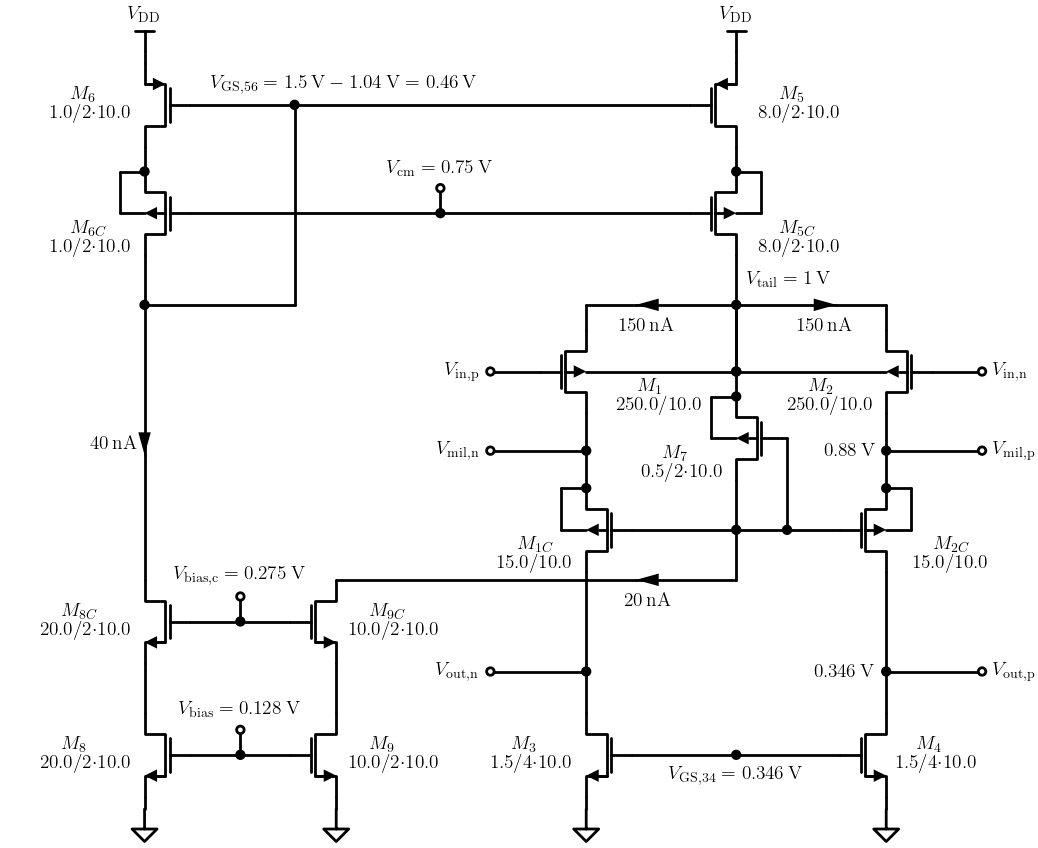

In [154]:
# Draw Telescopic Input Stage with W/L
import matplotlib
matplotlib.rcParams.update({
    "text.usetex": True,
    "font.family": "lmodern"
})
import schemdraw as sd
import schemdraw.elements as elm
sd.svgconfig.svg2 = False
with sd.Drawing() as d:
    d.config(unit=2)
    d.config(fontsize=14)
    
    # Vbias
    elm.Dot(open=True).label(r'$V_\mathrm{bias} = 0.128\,\textrm{V}$', loc='top', ofst=0.15)
    elm.Line().down().length(0.5).dot()
    d.push()
    elm.Line().left().length(1)

    # M8
    M8 = elm.AnalogNFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_8 \\$'+str(w_8/1.0)+'/'+r'$2 \cdot$'+str(l_8/2.0), ofst=0.25)
    elm.Line().at(M8.source).down().length(0.25)
    gndDot = d.here
    elm.GroundSignal()
    elm.Line().at(M8.drain).up().length(1)

    # M8c
    M8c = elm.AnalogNFet(offset_gate=False).anchor('source').theta(0).label(r'$M_{8C} \\$'+str(w_8/1.0)+'/'+r'$2 \cdot$'+str(l_8/2.0), ofst=0.25)
    elm.Line().at(M8c.gate).right().length(1).dot()
    d.push()
    elm.Line().up().length(0.5)
    elm.Dot(open=True).label(r'$V_\mathrm{bias,c} = 0.275\,\textrm{V}$', loc='top', ofst=0.15)
    d.pop()
    elm.Line().right().length(1)

    # M9
    d.pop()
    elm.Line().right().length(1)
    M9 = elm.AnalogNFet(offset_gate=False).anchor('gate').theta(0).label(r'$M_9 \\$'+str(w_9/1.0)+'/'+r'$2 \cdot$'+str(l_9/2.0), ofst=-3.0).reverse()
    elm.Line().at(M9.source).down().toy(gndDot)
    elm.GroundSignal()

    # M9c
    elm.Line().at(M9.drain).up().length(1)
    M9c = elm.AnalogNFet(offset_gate=False).anchor('source').theta(0).label(r'$M_{9C} \\$'+str(w_9/1.0)+'/'+r'$2 \cdot$'+str(l_9/2.0), ofst=-3.0).reverse()

    # High-Swing Current Mirror
    # M6c
    elm.Line().at(M8c.drain).up().length(2.5)
    elm.Arrowhead(headwidth=0.25, headlength=0.45).label(r'40\,nA', loc='top', ofst=-0.1).reverse()
    elm.Line().up().length(3).dot()
    d.push()
    elm.Line().up().length(1)
    M6c = elm.AnalogPFet(offset_gate=False, bulk=True).anchor('drain').theta(0).label(r'$M_{6C} \\$'+str(w_6c/1.0)+'/'+r'$2 \cdot$'+str(l_6c/2.0), ofst=(-0.25, -0.5))
    elm.Line().at(M6c.bulk).left().length(0.5)
    elm.Line().up().toy(M6c.source)
    elm.Line().right().tox(M6c.source).dot()
    elm.Line().at(M6c.gate).right().length(5).dot()
    d.push()
    elm.Line().up().length(0.5)
    elm.Dot(open=True).label(r'$V_\mathrm{cm} = 0.75\,\textrm{V}$', loc='top', ofst=0.15)
    d.pop()
    elm.Line().right().length(5)

    # M5c
    M5c = elm.AnalogPFet(offset_gate=False, bulk=True).anchor('gate').theta(0).label(r'$M_{5C} \\$'+str(w_5c/1.0)+'/'+r'$2 \cdot$'+str(l_5c/2.0), ofst=(3.0, -0.5)).reverse()
    elm.Line().at(M5c.bulk).right().length(0.5)
    elm.Line().up().toy(M5c.source)
    elm.Line().left().tox(M5c.source).dot()

    # M5
    elm.Line().at(M5c.source).up().length(0.5)
    M5 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{5} \\$'+str(w_5/1.0)+'/'+r'$2 \cdot$'+str(l_5/2.0), ofst=-3.0).reverse()
    elm.Line().at(M5.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)

    # M6
    elm.Line().at(M6c.source).up().length(0.5)
    M6 = elm.AnalogPFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{6} \\$'+str(w_6/1.0)+'/'+r'$2 \cdot$'+str(l_6/2.0), ofst=0.25)
    elm.Line().at(M6.source).up().length(0.25)
    elm.Vdd().label('$V_\mathrm{DD}$', loc='top', ofst=0.15)
    d.pop()
    elm.Line().right().length(3)
    elm.Line().up().toy(M6.gate)
    elm.Dot(open=False).label(r'$V_\mathrm{GS,56} = 1.5\,\textrm{V} - 1.04\,\textrm{V} = 0.46\,\textrm{V}$', loc='top', ofst=(1, 0.15))
    d.push()
    elm.Line().left().tox(M6.gate)
    d.pop()
    elm.Line().right().tox(M5.gate)

    # Diff. Pair
    elm.Line().at(M5c.drain).down().length(1)
    elm.Dot(open=False).label(r'$V_\mathrm{tail} = 1\,\textrm{V}$', loc='right', ofst=(0.15, 0.5))
    tailDot = d.here
    d.push()

    # M1
    elm.Line().left().length(2.0)
    elm.Arrowhead(headwidth=0.25, headlength=0.45).label(r'150\,nA', loc='bottom', ofst=0.0)
    elm.Line().left().length(1.0)
    elm.Line().down().length(0.5)
    M1 = elm.AnalogPFet(offset_gate=False, bulk=True).anchor('source').theta(0).label(r'$M_{1} \\$'+str(w_12/1.0)+'/'+str(l_12/1.0), ofst=(3.25, -0.5)).reverse()
    elm.Line().at(M1.bulk).right().tox(tailDot).dot()
    elm.Line().up().toy(tailDot)
    elm.Line().at(M1.gate).left().length(1)
    elm.Dot(open=True).label('$V_\mathrm{in,p}$', loc='left', ofst=0.15)
    vinpDot = d.here

    # M2
    d.pop()
    elm.Line().right().length(2.0)
    elm.Arrowhead(headwidth=0.25, headlength=0.45).label(r'150\,nA', loc='bottom', ofst=0.0)
    elm.Line().right().length(1.0)
    elm.Line().down().length(0.5)
    M2 = elm.AnalogPFet(offset_gate=False, bulk=True).anchor('source').theta(0).label(r'$M_{2} \\$'+str(w_12/1.0)+'/'+str(l_12/1.0), ofst=(-0.25, -0.5))
    elm.Line().at(M2.bulk).left().tox(tailDot).dot()
    elm.Line().up().toy(tailDot)
    elm.Line().at(M2.gate).right().length(1)
    elm.Dot(open=True).label('$V_\mathrm{in,n}$', loc='right', ofst=0.15)
    vinnDot = d.here

    # Vmiln
    elm.Line().at(M1.drain).down().length(0.75).dot()
    d.push()
    elm.Line().left().tox(vinpDot)
    elm.Dot(open=True).label('$V_\mathrm{mil,n}$', loc='left', ofst=0.15)
    d.pop()
    elm.Line().down().length(0.75)

    # M1c
    M1c = elm.AnalogPFet(offset_gate=False, bulk=True).anchor('source').theta(0).label(r'$M_{1C} \\$'+str(w_12c/1.0)+'/'+str(l_12c/1.0), ofst=(-0.25, -0.5))
    elm.Line().at(M1c.bulk).left().length(0.5)
    elm.Line().up().toy(M1c.source)
    elm.Line().right().tox(M1c.source).dot()

    # M7
    elm.Line().at(M1c.gate).right().tox(tailDot).dot()
    elm.Line().up().length(1)
    M7 = elm.AnalogPFet(offset_gate=False, bulk=True).anchor('drain').theta(0).label(r'$M_{7} \\$'+str(w_7/1.0)+'/'+r'$2 \cdot$'+str(l_7/2.0), ofst=(-0.25, -0.5))
    elm.Line().at(M7.source).toy(M1.bulk)
    elm.Line().at(M7.bulk).left().length(0.5)
    elm.Line().up().toy(M7.source)
    elm.Line().right().tox(M7.source).dot()
    elm.Line().at(M7.gate).right().length(0.1)
    elm.Line().down().toy(M1c.gate).dot()

    # Vmilp
    elm.Line().at(M2.drain).down().length(0.75)
    elm.Dot(open=False).label(r'$0.88\,\textrm{V}$', loc='left', ofst=0.15)
    d.push()
    elm.Line().right().tox(vinnDot)
    elm.Dot(open=True).label('$V_\mathrm{mil,p}$', loc='right', ofst=0.15)
    d.pop()
    elm.Line().down().length(0.75)

    # M2c
    M2c = elm.AnalogPFet(offset_gate=False, bulk=True).anchor('source').theta(0).label(r'$M_{2C} \\$'+str(w_12c/1.0)+'/'+str(l_12c/1.0), ofst=(3.0, -0.5)).reverse()
    elm.Line().at(M2c.bulk).right().length(0.5)
    elm.Line().up().toy(M2c.source)
    elm.Line().left().tox(M2c.source).dot()
    elm.Line().at(M2c.gate).left().tox(M7.drain)

    # Connection to M9c
    elm.Line().down().length(1)
    elm.Line().left().length(2.0)
    elm.Arrowhead(headwidth=0.25, headlength=0.45).label(r'20\,nA', loc='bottom', ofst=0.0)
    elm.Line().left().tox(M9c.drain)
    elm.Line().down().toy(M9c.drain)

    # Voutn
    elm.Line().at(M1c.drain).down().length(2.0).dot()
    d.push()
    elm.Line().left().tox(vinpDot)
    elm.Dot(open=True).label('$V_\mathrm{out,n}$', loc='left', ofst=0.15)
    d.pop()

    # M3
    elm.Line().down().toy(M9.drain)
    M3 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{3} \\$'+str(w_34/1.0)+'/'+r'$4 \cdot$'+str(l_34/4.0), ofst=0.25)
    elm.Line().at(M3.gate).right().tox(tailDot)
    elm.Dot(open=False).label(r'$V_\mathrm{GS,34} = 0.346\,\textrm{V}$', loc='bottom', ofst=0.15)
    elm.Line().at(M3.source).down().toy(gndDot)
    elm.GroundSignal()

    # Voutp
    elm.Line().at(M2c.drain).down().length(2.0)
    elm.Dot(open=False).label(r'$0.346\,\textrm{V}$', loc='left', ofst=0.15)
    d.push()
    elm.Line().right().tox(vinnDot)
    elm.Dot(open=True).label('$V_\mathrm{out,p}$', loc='right', ofst=0.15)
    d.pop()

    # M4
    elm.Line().down().toy(M9.drain)
    M4 = elm.AnalogNFet(offset_gate=False).anchor('drain').theta(0).label(r'$M_{4} \\$'+str(w_34/1.0)+'/'+r'$4 \cdot$'+str(l_34/4.0), ofst=-2.75).reverse()
    elm.Line().at(M4.gate).left().tox(tailDot)
    elm.Line().at(M4.source).down().toy(gndDot)
    elm.GroundSignal()

    # Save the schematic
    d.save('figures/amplifier_core/telescopic_input_stage_WL_circuit.svg')
    d.save('figures/amplifier_core/telescopic_input_stage_WL_circuit.pdf')

## Amplifier Core

Total DC open-loop gain

In [155]:
# Calculate the total DC open-loop gain of the amplifier core without R_1_CMFB / R_2_CMFB (SC CMFB)
A_ol_0_wo_R = A_ol_0_tele_wo_R * A_ol_0_pp_wo_R
A_ol_0_wo_R_dB = A_ol_0_tele_wo_R_dB + A_ol_0_pp_wo_R_dB
print('A_ol_0_wo_R_dB =', round(float(A_ol_0_wo_R), 2), '/', round(float(A_ol_0_wo_R_dB), 2), 'dB without R_1_CMFB / R_2_CMFB (SC CMFB)')

# Calculate the total DC open-loop gain of the amplifier core with R_1_CMFB / R_2_CMFB
A_ol_0 = A_ol_0_tele * A_ol_0_pp
A_ol_0_dB = A_ol_0_tele_dB + A_ol_0_pp_dB
print('A_ol_0 =', round(float(A_ol_0), 2), '/', round(float(A_ol_0_dB), 2), 'dB with R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm and R_2_CMFB =', round(float(R_2_CMFB) * 1e-6, 2), 'MOhm')

A_ol_0_wo_R_dB = 22978.99 / 87.23 dB without R_1_CMFB / R_2_CMFB (SC CMFB)
A_ol_0 = 3357.32 / 70.52 dB with R_1_CMFB = 25.46 MOhm and R_2_CMFB = 25.46 MOhm


Open-loop voltage gain error

In [156]:
# calculate voltage gain error without R_1_CMFB / R_2_CMFB (SC CMFB)
gain_error_wo_R = A_ol_0_wo_R / (1 + A_ol_0_wo_R)
print('voltage gain error without R_1_CMFB / R_2_CMFB (SC CMFB) =', round((1 - gain_error_wo_R) * 100, 4), '%')

# calculate voltage gain error with R_1_CMFB / R_2_CMFB
gain_error = A_ol_0 / (1 + A_ol_0)
print('voltage gain error with R_1_CMFB / R_2_CMFB =', round((1 - gain_error) * 100, 4), '%')

voltage gain error without R_1_CMFB / R_2_CMFB (SC CMFB) = 0.0044 %
voltage gain error with R_1_CMFB / R_2_CMFB = 0.0298 %


Total power consumption

In [157]:
# Calculate the total power consumption of the amplifier core

i_bmr = 2 * Ibias
print('i_bmr = 2 * Ibias =', round(2 * Ibias * 1e9, 1), 'nA')

i_tele = i_tail + i_m8
print('i_tele = i_tail + i_m8 =', round(i_tele * 1e9, 1), 'nA')

i_pp = i_m14 + 2 * (i_m1011 + i_m1821)
print('i_pp = i_m14 + 2 * (i_m1011 + i_m1821) =', round(i_pp * 1e9, 1), 'nA')

i_tot = i_bmr + i_tele + i_pp
print('i_tot =', round(i_tot * 1e9, 1), 'nA')

P_tot = VDD * i_tot
print('P_tot =', round(P_tot * 1e6, 2), 'uW')

i_bmr = 2 * Ibias = 20.0 nA
i_tele = i_tail + i_m8 = 360.0 nA
i_pp = i_m14 + 2 * (i_m1011 + i_m1821) = 525.0 nA
i_tot = 905.0 nA
P_tot = 1.36 uW


Simulation with idealized CMFBs (R_1_CMFB / R_2_CMFB)

In [158]:
# Print out final design values
print('Amplifier Core performance summary:')
print('-----------------------------------------------')
print('total supply current of amplifier core =', round(float(915.9), 1), 'nA')
print('total supply current of amplifier core (enable down) =', round(float(6.41), 1), 'nA')
print('Vcm_out =', round(float(0.739), 3), 'V')
print(f"vout_pp = vout_pp_max - vout_pp_min (linear) = {round(float(1.28), 3)} - {round(float(0.20), 3)} = {round(float(1.28-0.20), 2)} V at VDD = {round(float(VDD), 2)} V")
print(f"vout_pp = vout_pp_max - vout_pp_min = {round(float(1.474), 2)} - {round(float(32.64e-3), 4)} = {round(float(1.474-32.64e-3), 3)} V at VDD = {round(float(VDD), 2)} V")
print('A_ol_0 =', round(float(76.51), 2), 'dB with R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm')
print('f_c =', round(float(69.17), 2), 'Hz with R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm')
print('Phase Margin =', round(float(-41.80), 2), '° @ GBWP --> not unity gain stable!')
print('GBWP = A_ol_0_tele * f_c_tele =', round(float(206.72), 2), 'kHz = f_u_tele')
print('f_z ~', round(float(2), 2), 'MHz')
print('CMRR_0 =', round(float(159.19), 2), 'dB @ 1Hz with R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm')
print('PSRR_0 =', round(float(127), 2), 'dB @ 1Hz with R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm')
print('Zin_CM_0 =', round(float(1.1), 2), 'TOhm with R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm')
print('Zin_DM_0 =', round(float(3.6), 2), 'MOhm with R_1_CMFB =', round(float(R_1_CMFB) * 1e-6, 2), 'MOhm')
print('input-referred noise from 0.15 to', round(B, 2), 'Hz =', round(4.37, 1), 'uVrms')
print('output-referred noise from 0.15 to', round(B, 2), 'Hz =', round(22.68, 1), 'mVrms')
print('input-referred noise from 0.30 to', round(B, 2), 'Hz =', round(4.22, 1), 'uVrms')
print('output-referred noise from 0.30 to', round(B, 2), 'Hz =', round(21.48, 1), 'mVrms')
print('rising and falling slewing time ~', round(10, 2), 'us')
print('-----------------------------------------------')

Amplifier Core performance summary:
-----------------------------------------------
total supply current of amplifier core = 915.9 nA
total supply current of amplifier core (enable down) = 6.4 nA
Vcm_out = 0.739 V
vout_pp = vout_pp_max - vout_pp_min (linear) = 1.28 - 0.2 = 1.08 V at VDD = 1.5 V
vout_pp = vout_pp_max - vout_pp_min = 1.47 - 0.0326 = 1.441 V at VDD = 1.5 V
A_ol_0 = 76.51 dB with R_1_CMFB = 25.46 MOhm
f_c = 69.17 Hz with R_1_CMFB = 25.46 MOhm
Phase Margin = -41.8 ° @ GBWP --> not unity gain stable!
GBWP = A_ol_0_tele * f_c_tele = 206.72 kHz = f_u_tele
f_z ~ 2.0 MHz
CMRR_0 = 159.19 dB @ 1Hz with R_1_CMFB = 25.46 MOhm
PSRR_0 = 127.0 dB @ 1Hz with R_1_CMFB = 25.46 MOhm
Zin_CM_0 = 1.1 TOhm with R_1_CMFB = 25.46 MOhm
Zin_DM_0 = 3.6 MOhm with R_1_CMFB = 25.46 MOhm
input-referred noise from 0.15 to 500 Hz = 4.4 uVrms
output-referred noise from 0.15 to 500 Hz = 22.7 mVrms
input-referred noise from 0.30 to 500 Hz = 4.2 uVrms
output-referred noise from 0.30 to 500 Hz = 21.5 mVrms
ri

Simulation with SC CMFBs

In [159]:
# Amplifier Core with SC circuits is successfully simulated using transient analysis.

## Further improvements

In [160]:
# Further improvements:
# --> If the CMRR should be further increased, the output resistance of the high-swing current mirror can be improved by gain boosting (e.g. Säckinger implementation, Fath or Sec. 6.3.3 in Carusone)